# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
#!pip install ibmos2spark

In [3]:
#import ibmos2spark
#@hidden_cell
#credentials = {
#    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
#    'service_id': 'iam-ServiceId-095a6003-6269-486e-8bf7-22f7856e2a33',
#    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
#    'api_key': '5rd4JjbLDtIKnWhmwbTnQGOA7c5tDfii-FOwpOKtsX-V'
#}
#
#configuration_name = 'os_2746aaba51d24cd3a479f8d2da307b1d_configs'
#cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

In [4]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import avg
from pyspark.sql.functions import col
from pyspark.sql.functions import concat
from pyspark.sql.functions import desc
from pyspark.sql.functions import explode
from pyspark.sql.functions import lit
from pyspark.sql.functions import min
from pyspark.sql.functions import max
from pyspark.sql.functions import split
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import isnan
from pyspark.sql.functions import count
from pyspark.sql.functions import dayofyear
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType
from pyspark.sql.types import ArrayType

from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import SparseVector
from pyspark.ml.linalg import DenseVector 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

from os import path 

import re

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn

from IPython.core.display import display, HTML

try:
    import cPickle as pickle
except:
    import pickle

import requests

In [5]:
! pip install sparksql-magic

In [6]:
%reload_ext sparksql_magic

In [7]:
!pip install git+https://github.com/rossant/ipycache --upgrade

  Cloning https://github.com/rossant/ipycache to /tmp/pip-req-build-b8_awpb1
  Running setup.py bdist_wheel for ipycache ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ri89f38r/wheels/59/ef/bc/c8355ab975f0ebc2aa1a95cdd75ea1f333f2143dc68dd50404
Successfully built ipycache
  Found existing installation: ipycache 0.1.5.dev0
    Uninstalling ipycache-0.1.5.dev0:
      Successfully uninstalled ipycache-0.1.5.dev0


In [8]:
%reload_ext ipycache

/opt/conda/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [9]:
# create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with
# the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

In [10]:
# url = 'http://s3-api.us-geo.objectstorage.service.networklayer.com/sparkify-donotdelete-pr-42ldwg6hxv8yav/medium-sparkify-event-data.json'
# r = requests.get(url)
# r.json()

In [11]:
df = spark.read.json('mini_sparkify_event_data.json')
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [12]:
df = df.withColumn('day', dayofyear(from_unixtime(df.ts/1000, 'yyyy-MM-dd')))

In [13]:
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', day=274),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', day=274)]

In [14]:
df.createOrReplaceTempView("log_t")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [15]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- day: integer (nullable = true)



In [16]:
%%cache summary.plk summary
summary = spark.createDataFrame(df.describe().where("summary = 'count'").collect()).toPandas().head(10)

[Saved variables 'summary' to file '/home/workspace/summary.plk'.]


In [17]:
summary.style.hide_index()

summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,day
count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500,286500


we can see that not all rows have equal number of count. This indicates that there are null values in each column. We can drop those null values especially in userId and page coulmn to get clean dataset for analysis

In [18]:
df = df.filter(df.page.isNotNull()).filter(df.userId.isNotNull())

In [19]:
%%cache summary1.plk summary1
## cache the long running queries and dont execute and and show only result
summary1 = spark.createDataFrame(df.describe().where("summary = 'count'").collect()).toPandas().head(5)

[Saved variables 'summary1' to file '/home/workspace/summary1.plk'.]


In [20]:
summary1.style.hide_index()

summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,day
count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500,286500


The dataset has only no null values in userIds, ts, status, page, level, itemInsession, auth. But there are other field like artist, lenght, song are found. Let us see if these are valid cases be have null values

In [21]:
df.createOrReplaceTempView("log_table")

In [22]:
spark.sql("select distinct(page) from log_table \
           where song is not null \
           and artist is not null \
           and length is not null \
        ").toPandas()

,page
0,NextSong


It is understandable that field artist, lenght, song are log only for NextSong page where it makes sense. Let us find out why the fields like firstName, gender, lastname, registration,  userAgent are not logged

In [23]:
spark.sql("select distinct(auth) from log_table \
            where song is null ").toPandas()

,auth
0,Logged Out
1,Cancelled
2,Guest
3,Logged In


In [24]:
spark.sql("select distinct(auth) from log_table \
           where firstName is not null \
           and gender is not null \
           and lastName is not null \
           and registration is not null \
           and userAgent is not null \
        ").toPandas()

,auth
0,Cancelled
1,Logged In


We could see the firstName, gender, lastname, registration,  userAgent are not logged for users we were never registered. that is Guest users. This names sense as we will never have such details with out registering for the service . Now the data is good we start the Exploratory analysis

# Exploratory Data Analysis
When working with the full dataset, EDA is performed by loading a small subset of the data and doing basic manipulations within Spark. 

### Define Churn

Churn can be defined as user leaving the service. This is indicated by presence of `Cancellation Confirmation` page. `Downgrade event` can also be early indicator of churn

After the EDA analysis a column `isCancelled` is use as the label for the model indicating user using the Cancellation Confirmation events to define churn, which happen for both paid and free users.

### Explore Data
Exploratory data analysis is done to observe the behavior for users who stayed vs users who churned. We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Start with the pages users visited

In [25]:
%%sparksql  -l 999

select DISTINCT(page)FROM log_table

page
Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About


###### As this is timeseriese data, Let us find the what is time period of data available

In [26]:
spark.sql("select from_unixtime(min(ts)/1000) as start_date, \
                  from_unixtime(max(ts)/1000) as end_date \
          from log_table").toPandas().style.hide_index()

start_date,end_date
2018-10-01 00:01:57,2018-12-03 01:11:16


The log seems to have around 2 months of data strting from `2018-10-01 to 2018-12-03`

In [27]:
%%sparksql -l 100
SELECT count(distinct( userId))
  FROM log_table

count(DISTINCT userId)
226


There are `226` distinct registered users - they can register as paid or free level

In [28]:
%%sparksql -l 100
SELECT COUNT(DISTINCT(userId))
  FROM log_t
 WHERE page = 'Cancel'

count(DISTINCT userId)
52


There are are `52` cancelled users out of `226` users which is around `23.3%`

In [29]:
%%sparksql -l 100
SELECT 
       (SELECT COUNT(DISTINCT(userId)) 
          FROM log_table
         WHERE page  = 'Register'
           AND level = 'free'         
       ) AS Free_registered_users
      ,(SELECT COUNT(DISTINCT(userId)) 
          FROM log_table
         WHERE page  = 'Register'
           AND level = 'paid'
       ) AS Paid_registered_users
      ,(SELECT COUNT(DISTINCT(userId)) 
          FROM log_table
         WHERE page  = 'Upgrade'
           AND level = 'free'       
       ) AS Upgraded_users 
      ,(SELECT COUNT(DISTINCT(userId)) 
          FROM log_table
         WHERE page  = 'Downgrade'
           AND level = 'paid'
       ) AS Downgrade_users
      ,(SELECT COUNT(DISTINCT(userId)) 
          FROM log_table
         WHERE page  = 'Cancel'
           AND level = 'free'         
       ) AS Free_cancelled_users 
      ,(SELECT COUNT(DISTINCT(userId)) 
          FROM log_table
         WHERE page  = 'Cancel'
           AND level = 'paid'         
       ) AS paid_cancelled_users      
  FROM log_table
 LIMIT 1

Free_registered_users,Paid_registered_users,Upgraded_users,Downgrade_users,Free_cancelled_users,paid_cancelled_users
1,0,168,154,21,31


The above counts of user indicate how users actions over the timeperiod of the dataset. There is overlap between these buclekts of user. So total user here will be more than the total distinct user we found in the dataset. Let us find the distribution of cancelled users by listening time and time since registered and frequency of Advert Rolls. I believe these factors could gauge the interest of the user to stick on to the service as paid user

###### First let us look at the per user listening time per week for cancelled and registered user by paid and free user levels. This gives us a view of how much time user spends on listening to song each week

In [30]:
%%cache df_c.plk df_c
df_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,sum(a.length) as listen_time_cancelled_user
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'NextSong'
   AND b.page = 'Cancel'
 GROUP by week
         ,a.level
 ORDER by week
         ,a.level
''').toPandas()

[Saved variables 'df_c' to file '/home/workspace/df_c.plk'.]


In [31]:
%%cache df_r.plk df_r
df_r = spark.sql('''
-- Registered users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,sum(a.length) as listen_time_Registered_user
      ,count(distinct a.userId) as user_R
  FROM log_table a
 WHERE a.page = 'NextSong'
   AND a.userId not in 
       ( select userId from log_table b
          where page = 'Cancel'
            and a.userId = b.userId 
       )
 GROUP by week
      ,a.level
 ORDER by week
      ,a.level
''').toPandas()

[Saved variables 'df_r' to file '/home/workspace/df_r.plk'.]


In [32]:
# Caputure the result of both the queries as pandas dataframe
df_listen = pd.merge(df_c, df_r, on=['week', 'level'])

In [33]:
df_listen['prop_time_can_user'] = df_listen['listen_time_cancelled_user'] / df_listen['user_C'] 
df_listen['prop_time_reg_user'] = df_listen['listen_time_Registered_user'] / df_listen['user_R'] 

In [34]:
df_listen.style.hide_index()

week,level,listen_time_cancelled_user,user_C,listen_time_Registered_user,user_R,prop_time_can_user,prop_time_reg_user
40,free,716262,38,1.58541e+06,91,18849,17422.1
40,paid,1.06224e+06,18,2.29617e+06,53,59013.6,43324
41,free,577118,26,984930,71,22196.8,13872.3
41,paid,1.82513e+06,21,3.375e+06,61,86910.9,55327.8
42,free,424992,23,1.15295e+06,74,18477.9,15580.5
42,paid,1.35361e+06,21,4.37967e+06,70,64457.6,62566.8
43,free,253481,14,725066,55,18105.8,13183
43,paid,565434,15,4.51502e+06,75,37695.6,60200.2
44,free,155472,12,773093,54,12956,14316.5
44,paid,943564,15,6.00992e+06,83,62904.3,72408.7


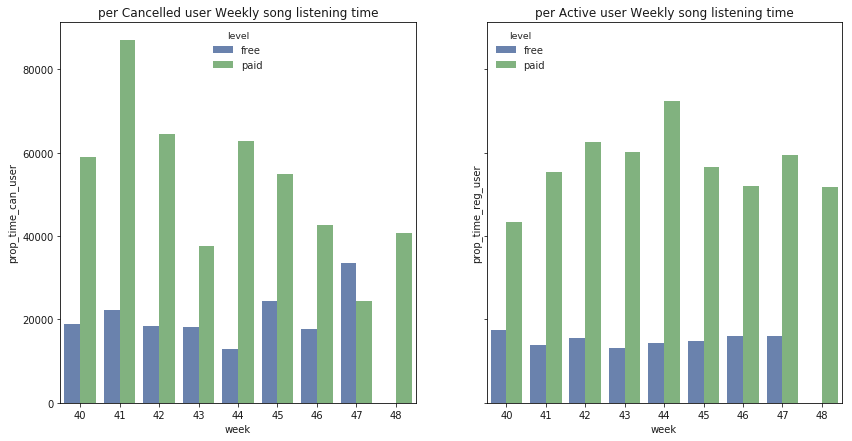

In [35]:
# Plot the df_listen figures as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_listen, x='week', y='prop_time_can_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("per Cancelled user Weekly song listening time")

ax2 = sbn.barplot(data=df_listen, x='week', y='prop_time_reg_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("per Active user Weekly song listening time")

plt.show();

The paid user seems to spend more time as expected. But it is surprising to see per cancelled users send more time listening to song in a week than per registered user especially in the last week. 

###### Let us now considered number of sessions per week for cancelled and registered user.

In [36]:
%%cache df_c_s.plk df_c_s
df_c_s = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(distinct a.sessionId) as Can_user_sessions
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'NextSong'
   AND b.page = 'Cancel'
 GROUP by week
         ,a.level
 ORDER by week
         ,a.level
''').toPandas()

[Saved variables 'df_c_s' to file '/home/workspace/df_c_s.plk'.]


In [37]:
%%cache df_r_s.plk df_r_s
df_r_s = spark.sql('''
-- Registered users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(distinct a.sessionId) as Reg_user_sessions
      ,count(distinct a.userId) as user_R
  FROM log_table a
 WHERE a.page = 'NextSong'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP by week
      ,a.level
 ORDER by week
      ,a.level
''').toPandas()

[Saved variables 'df_r_s' to file '/home/workspace/df_r_s.plk'.]


In [38]:
# Caputure the result of both the queries as pandas dataframe
df_session = pd.merge(df_c_s, df_r_s, on=['week', 'level'])

In [39]:
df_session['prop_time_can_user'] = df_session['Can_user_sessions'] / df_session['user_C'] 
df_session['prop_time_reg_user'] = df_session['Reg_user_sessions'] / df_session['user_R'] 

In [40]:
df_session.style.hide_index()

week,level,Can_user_sessions,user_C,Reg_user_sessions,user_R,prop_time_can_user,prop_time_reg_user
40,free,91,38,208,91,2.39474,2.28571
40,paid,43,18,115,53,2.38889,2.16981
41,free,67,26,142,71,2.57692,2
41,paid,62,21,144,61,2.95238,2.36066
42,free,52,23,163,74,2.26087,2.2027
42,paid,49,21,174,70,2.33333,2.48571
43,free,32,14,96,55,2.28571,1.74545
43,paid,33,15,188,75,2.2,2.50667
44,free,19,12,97,54,1.58333,1.7963
44,paid,43,15,206,83,2.86667,2.48193


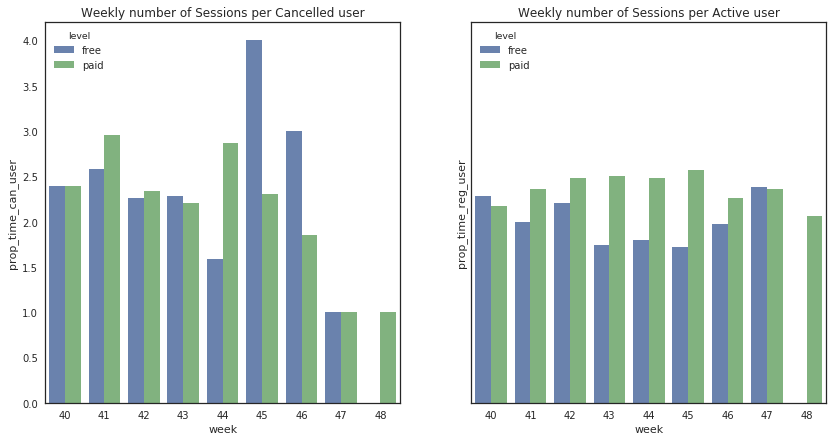

In [41]:
# Plot the df_listen figures as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_session, x='week', y='prop_time_can_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("Weekly number of Sessions per Cancelled user")

ax2 = sbn.barplot(data=df_session, x='week', y='prop_time_reg_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("Weekly number of Sessions per Active user")

plt.show();

The paid and registered user seems to have more number of session per week as compared to registered and free user as the graph 2. But tread is not very eveident with cancelled users.

###### Let us now see number of items per week which indicates the navigation the users

In [42]:
%%cache df_items_c.plk df_items_c
df_items_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_item
      ,count(distinct a.userId) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND b.page = 'Cancel'
 GROUP by week
        ,a.level
 ORDER by week
        ,a.level
''').toPandas()

[Saved variables 'df_items_c' to file '/home/workspace/df_items_c.plk'.]


In [43]:
df_items_c.head(15).style.hide_index()

week,level,Can_user_item,user_C
40,free,3870,39
40,paid,5048,18
41,free,3153,26
41,paid,8741,22
42,free,2282,23
42,paid,6469,21
43,free,1376,14
43,paid,2735,15
44,free,836,12
44,paid,4543,15


In [44]:
%%cache df_items_r.plk df_items_r
df_items_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Reg_user_items
      ,count(distinct a.userId) as user_R
  FROM log_table a \
 WHERE a.userId not in 
       ( SELECT userId 
           FROM log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP by week
         ,a.level
 ORDER by week
         ,a.level
''').toPandas()

[Saved variables 'df_items_r' to file '/home/workspace/df_items_r.plk'.]


In [45]:
df_items_r.head(15).style.hide_index()

week,level,Reg_user_items,user_R
40,free,8983,94
40,paid,11562,55
41,free,5516,72
41,paid,17041,63
42,free,6448,75
42,paid,21739,72
43,free,4120,56
43,paid,22434,77
44,free,4408,55
44,paid,29436,84


In [46]:
# Caputure the result of both the queries as pandas dataframe
df_items = pd.merge(df_c_s, df_r_s, on=['week', 'level'])
df_items['prop_items_can_user'] = df_items['Can_user_sessions'] / df_items['user_C'] 
df_items['prop_items_reg_user'] = df_items['Reg_user_sessions'] / df_items['user_R'] 
df_items.head(10).style.hide_index()

week,level,Can_user_sessions,user_C,Reg_user_sessions,user_R,prop_items_can_user,prop_items_reg_user
40,free,91,38,208,91,2.39474,2.28571
40,paid,43,18,115,53,2.38889,2.16981
41,free,67,26,142,71,2.57692,2
41,paid,62,21,144,61,2.95238,2.36066
42,free,52,23,163,74,2.26087,2.2027
42,paid,49,21,174,70,2.33333,2.48571
43,free,32,14,96,55,2.28571,1.74545
43,paid,33,15,188,75,2.2,2.50667
44,free,19,12,97,54,1.58333,1.7963
44,paid,43,15,206,83,2.86667,2.48193


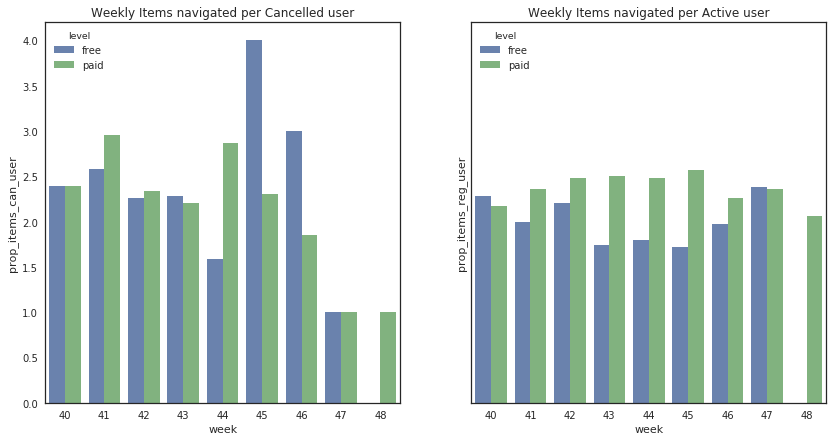

In [47]:
# Plot the df_items figures as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_items, x='week', y='prop_items_can_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("Weekly Items navigated per Cancelled user")

ax2 = sbn.barplot(data=df_items, x='week', y='prop_items_reg_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("Weekly Items navigated per Active user")

plt.show();

The number of items navigated per weeks trend is clear for free and paid active users. But the tread can not be clearly seen for cancelled users.

###### Now let us consider number of Thumbu up, Thumbs down, Add friend events

In [48]:
%%cache df_thumbs_up_c.plk df_thumbs_up_c

# SQL to get the count of thumbs up per cancelled user by week

df_thumbs_up_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'Thumbs Up'
   AND b.page = 'Cancel'
 GROUP by 
       week
      ,a.level
 ORDER by 
       week
      ,a.level
''').toPandas()

[Saved variables 'df_thumbs_up_c' to file '/home/workspace/df_thumbs_up_c.plk'.]


In [49]:
%%cache df_thumbs_down_c.plk df_thumbs_down_c

# SQL to get the count of thumbs down per cancelled user by week

df_thumbs_down_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'Thumbs Down'
   AND b.page = 'Cancel'
 GROUP by 
       week
      ,a.level
 ORDER by 
       week
      ,a.level
''').toPandas()

[Saved variables 'df_thumbs_down_c' to file '/home/workspace/df_thumbs_down_c.plk'.]


In [50]:
%%cache df_add_friend_c.plk df_add_friend_c

# SQL to get the count of add friend event per cancelled user by week

df_add_friend_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'Add Friend'
   AND b.page = 'Cancel'
 GROUP by 
       week
      ,a.level
 ORDER by 
       week
      ,a.level
''').toPandas()

[Saved variables 'df_add_friend_c' to file '/home/workspace/df_add_friend_c.plk'.]


In [51]:
%%cache df_thumbs_up_r.plk df_thumbs_up_r

# SQL to get the count of thumbs up event per active user by week

df_thumbs_up_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  FROM log_table a
 WHERE a.page = 'Thumbs Up'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP by week
         ,a.level
         ,a.page
 ORDER by week
         ,a.level
         ,a.page
''').toPandas()

[Saved variables 'df_thumbs_up_r' to file '/home/workspace/df_thumbs_up_r.plk'.]


In [52]:
%%cache df_thumbs_down_r.plk df_thumbs_down_r

# SQL to get the count of thumbs down event per active user by week

df_thumbs_down_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  FROM log_table a
 WHERE a.page = 'Thumbs Down'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP BY week
         ,a.level
         ,a.page
 ORDER BY week
         ,a.level
         ,a.page
''').toPandas()

[Saved variables 'df_thumbs_down_r' to file '/home/workspace/df_thumbs_down_r.plk'.]


In [53]:
%%cache df_add_friend_r.plk df_add_friend_r

# SQL to get the count of add friend event per active user by week

df_add_friend_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  FROM log_table a
 WHERE a.page = 'Add Friend'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP by week
         ,a.level
         ,a.page
ORDER by week
         ,a.level
         ,a.page
''').toPandas()

[Saved variables 'df_add_friend_r' to file '/home/workspace/df_add_friend_r.plk'.]


In [54]:
# Calcuate per user events cancelled user
df_thumbs_up_c['event_per_user'] = df_thumbs_up_c['Can_user_event'] / df_thumbs_up_c['user_C'] 
df_thumbs_down_c['event_per_user'] = df_thumbs_down_c['Can_user_event'] / df_thumbs_down_c['user_C']
df_add_friend_c['event_per_user'] = df_add_friend_c['Can_user_event'] / df_add_friend_c['user_C'] 

# Calcuate per user events active user
df_thumbs_up_r['event_per_user'] = df_thumbs_up_r['active_user_event'] / df_thumbs_up_r['user_R'] 
df_thumbs_down_r['event_per_user'] = df_thumbs_down_r['active_user_event'] / df_thumbs_down_r['user_R']
df_add_friend_r['event_per_user'] = df_add_friend_r['active_user_event'] / df_add_friend_r['user_R'] 

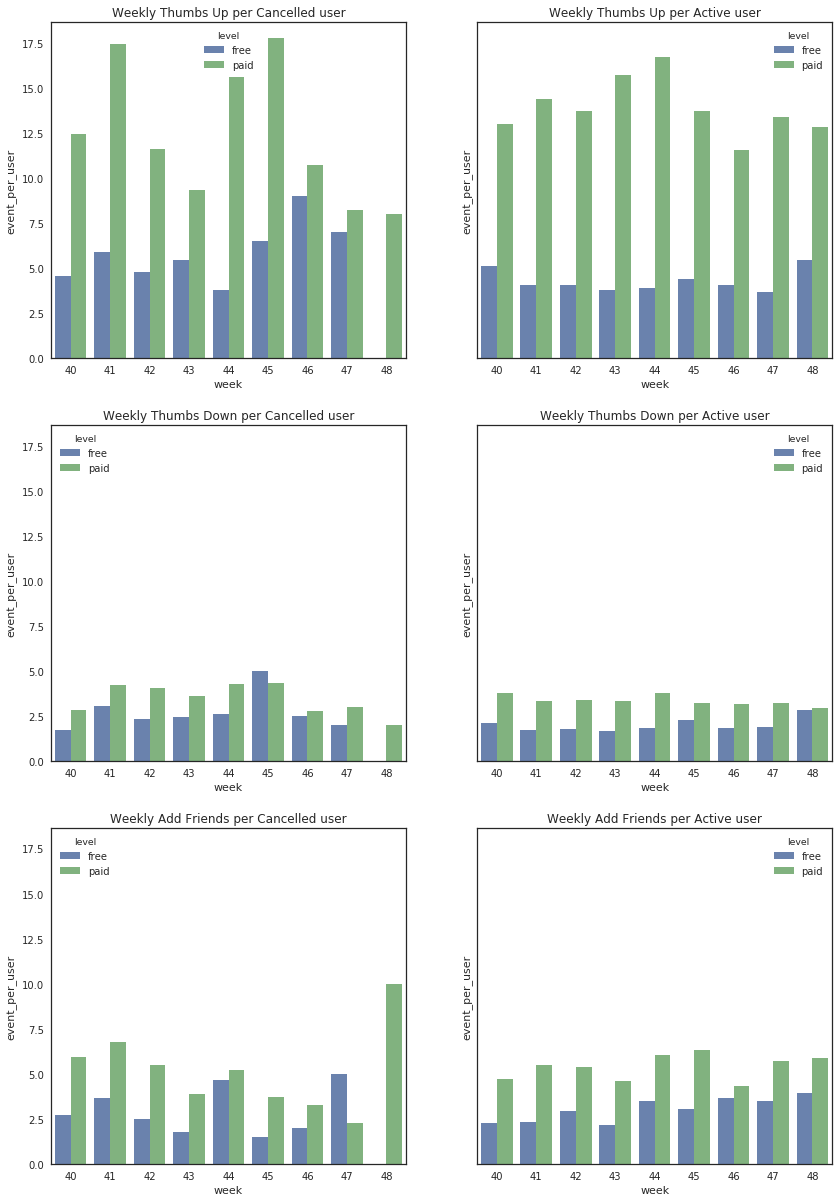

In [55]:
# Plot the events figures as graph
f, axes = plt.subplots(3, 2, figsize=(14, 21), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)


list_dfs = [[df_thumbs_up_c, df_thumbs_up_r],
            [df_thumbs_down_c, df_thumbs_down_r],
            [df_add_friend_c, df_add_friend_r],
           ]

titles = [["Weekly Thumbs Up per Cancelled user", "Weekly Thumbs Up per Active user" ],
          ["Weekly Thumbs Down per Cancelled user", "Weekly Thumbs Down per Active user" ],
          ["Weekly Add Friends per Cancelled user", "Weekly Add Friends per Active user" ],
         ]

for i,a in enumerate(axes):
    for j,ax in enumerate(a):
        ax = sbn.barplot(data=list_dfs[i][j], x='week', y='event_per_user', hue='level', ax=axes[i,j], saturation=0.50); 
        ax.set_title(titles[i][j]);

plt.show();

The above graphs shows Cancelled users and Active user are having faily same level of thumbs up and thumbs downs. cancel users have relatively added more friends than active users. This could be they are more enagaged with friends :)

###### Let us check the roll advert frequency for Active and cancelled users

In [56]:
%%cache df_roll_advert_c.plk df_roll_advert_c

# SQL to get the count of roll advert per cancelled user by week

df_roll_advert_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'Roll Advert'
   AND b.page = 'Cancel'
 GROUP by 
       week
      ,a.level
 ORDER by 
       week
      ,a.level
''').toPandas()

[Saved variables 'df_roll_advert_c' to file '/home/workspace/df_roll_advert_c.plk'.]


In [57]:
df_roll_advert_c.head(10).style.hide_index()

week,level,Can_user_event,user_C
40,free,303,36
40,paid,8,6
41,free,191,25
41,paid,12,8
42,free,163,21
42,paid,13,5
43,free,119,11
43,paid,8,4
44,free,58,9
44,paid,9,6


In [58]:
%%cache df_roll_advert_r.plk df_roll_advert_r

# SQL to get the count of advert event per active user by week

df_roll_advert_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  FROM log_table a
 WHERE a.page = 'Roll Advert'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP BY week
         ,a.level
         ,a.page
ORDER BY week
         ,a.level
         ,a.page
''').toPandas()

[Saved variables 'df_roll_advert_r' to file '/home/workspace/df_roll_advert_r.plk'.]


In [59]:
df_roll_advert_r.head(10).style.hide_index()

week,level,page,active_user_event,user_R
40,free,Roll Advert,545,77
40,paid,Roll Advert,16,15
41,free,Roll Advert,312,54
41,paid,Roll Advert,9,6
42,free,Roll Advert,385,66
42,paid,Roll Advert,26,13
43,free,Roll Advert,247,47
43,paid,Roll Advert,18,16
44,free,Roll Advert,247,51
44,paid,Roll Advert,33,20


In [60]:
# Calcuate per user events 
df_roll_advert_c['event_per_user'] = df_roll_advert_c['Can_user_event'] / df_roll_advert_c['user_C'] 
df_roll_advert_r['event_per_user'] = df_roll_advert_r['active_user_event'] / df_roll_advert_r['user_R'] 

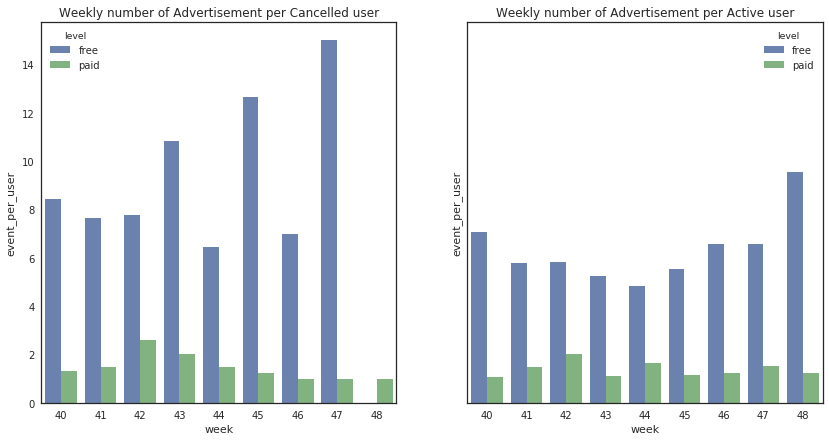

In [61]:
# Plot the roll advert data as graph
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_roll_advert_c, x='week', y='event_per_user', hue='level', ax=axes[0], saturation=0.50);
ax1.set_title("Weekly number of Advertisement per Cancelled user")

ax2 = sbn.barplot(data=df_roll_advert_r, x='week', y='event_per_user', hue='level', ax=axes[1], saturation=0.50);
ax2.set_title("Weekly number of Advertisement per Active user")

plt.show();

Looks like the `cancelled` users have got more adverts that `active` users. THis is possible because of more time they have spent and overall more songs they have listen the remaining active users. 

###### Let us check the Help page ; Save settting page visits for Active and cancelled users

In [62]:
%%cache df_help_c.plk df_help_c

# SQL to get the count of help per cancelled user by week

df_help_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'Help'
   AND b.page = 'Cancel'
 GROUP by 
       week
      ,a.level
 ORDER by 
       week
      ,a.level
''').toPandas()

[Saved variables 'df_help_c' to file '/home/workspace/df_help_c.plk'.]


In [63]:
df_help_c.head(10).style.hide_index()

week,level,Can_user_event,user_C
40,free,22,14
40,paid,24,11
41,free,20,11
41,paid,47,15
42,free,16,9
42,paid,32,14
43,free,6,3
43,paid,10,7
44,free,4,4
44,paid,23,11


In [64]:
%%cache df_help_r.plk df_help_r

# SQL to get the count of Help page event per active user by week

df_help_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  FROM log_table a
 WHERE a.page = 'Help'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP BY week
         ,a.level
         ,a.page
 ORDER BY week
         ,a.level
         ,a.page
''').toPandas()

[Saved variables 'df_help_r' to file '/home/workspace/df_help_r.plk'.]


In [65]:
df_help_r.head(10).style.hide_index()

week,level,page,active_user_event,user_R
40,free,Help,75,37
40,paid,Help,70,28
41,free,Help,35,22
41,paid,Help,88,36
42,free,Help,47,29
42,paid,Help,123,47
43,free,Help,24,15
43,paid,Help,130,43
44,free,Help,48,17
44,paid,Help,179,56


In [66]:
%%cache df_settings_c.plk df_settings_c

# SQL to get the count of help per cancelled user by week

df_settings_c = spark.sql('''
-- cancelled user
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,count(a.itemInSession) as Can_user_event
      ,count(distinct(a.userId)) as user_C
  FROM log_table a
      ,log_table b
 WHERE a.userId = b.userId
   AND a.page = 'Save Settings'
   AND b.page = 'Cancel'
 GROUP by 
       week
      ,a.level
 ORDER by 
       week
      ,a.level
''').toPandas()

[Saved variables 'df_settings_c' to file '/home/workspace/df_settings_c.plk'.]


In [67]:
df_settings_c.head(10).style.hide_index()

week,level,Can_user_event,user_C
40,free,5,5
40,paid,8,6
41,free,7,6
41,paid,9,8
42,free,5,5
42,paid,13,8
43,free,2,2
43,paid,2,2
44,free,1,1
44,paid,2,2


In [68]:
%%cache df_settings_r.plk df_settings_r

# SQL to get the count of Help page event per active user by week

df_settings_r = spark.sql('''
-- active users 
SELECT weekofyear(from_unixtime(a.ts/1000, 'yyyy-MM-dd')) as week
      ,a.level
      ,a.page
      ,count(a.itemInSession) as active_user_event
      ,count(distinct(a.userId)) as user_R
  FROM log_table a
 WHERE a.page = 'Save Settings'
   AND a.userId not in 
       ( SELECT userId from log_table b
          WHERE page = 'Cancel'
            AND a.userId = b.userId 
       )
 GROUP BY week
         ,a.level
         ,a.page
 ORDER BY week
         ,a.level
         ,a.page
''').toPandas()

[Saved variables 'df_settings_r' to file '/home/workspace/df_settings_r.plk'.]


In [69]:
df_settings_r.head(10).style.hide_index()

week,level,page,active_user_event,user_R
40,free,Save Settings,14,13
40,paid,Save Settings,9,8
41,free,Save Settings,7,6
41,paid,Save Settings,17,15
42,free,Save Settings,4,4
42,paid,Save Settings,21,16
43,free,Save Settings,5,5
43,paid,Save Settings,15,13
44,free,Save Settings,7,6
44,paid,Save Settings,35,28


In [70]:
# Calcuate per user events for help page visit
df_help_c['event_per_user'] = df_help_c['Can_user_event'] / df_help_c['user_C'] 
df_help_r['event_per_user'] = df_help_r['active_user_event'] / df_help_r['user_R'] 

# Calcuate per user events for save settings page visit
df_settings_c['event_per_user'] = df_settings_c['Can_user_event'] / df_settings_c['user_C'] 
df_settings_r['event_per_user'] = df_settings_r['active_user_event'] / df_settings_r['user_R'] 

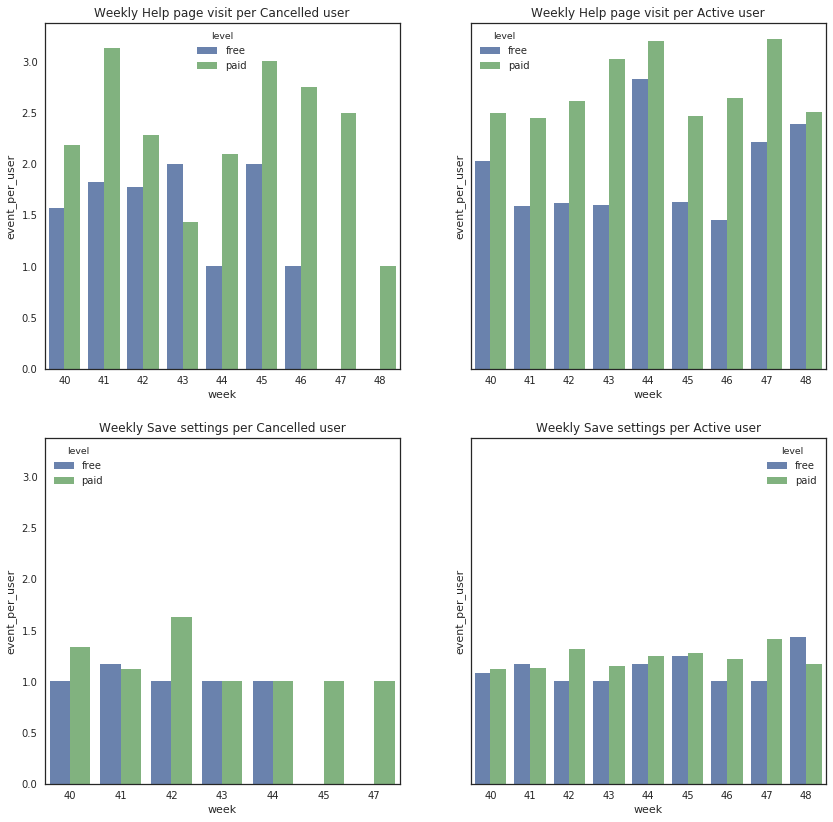

In [71]:
# Plot the events figures as graph
f, axes = plt.subplots(2, 2, figsize=(14, 14), sharey=True)

sbn.set(style="white", palette="muted", color_codes=True)


list_dfs = [[df_help_c, df_help_r],
            [df_settings_c, df_settings_r],
           ]

titles = [["Weekly Help page visit per Cancelled user", "Weekly Help page visit per Active user" ],
          ["Weekly Save settings per Cancelled user", "Weekly Save settings per Active user" ],
         ]

for i,a in enumerate(axes):
    for j,ax in enumerate(a):
        ax = sbn.barplot(data=list_dfs[i][j], x='week', y='event_per_user', hue='level', ax=axes[i,j], saturation=0.50); 
        ax.set_title(titles[i][j]);

plt.show();

Clearly the tread show `Active` users both `free` or `paid used Help pages more often `cancelled` users. `Save setting` seems to be of almost same frequency with `cancelled` and `active` user

###### Let us now consider how the individual song have contributed to Cancel, Downgrade and Upgrade.

In [72]:
%%cache df_song_c.plk df_song_c

df_song_c = spark.sql(
'''
SELECT a.song, count(distinct(a.userId)) as can_user
  FROM log_table a
      ,log_table b
WHERE a.userId = b.userId
  AND a.page = 'NextSong'
  AND b.page = 'Cancel'
GROUP by a.song
ORDER by 2 desc
LIMIT 50
''').toPandas()

[Saved variables 'df_song_c' to file '/home/workspace/df_song_c.plk'.]


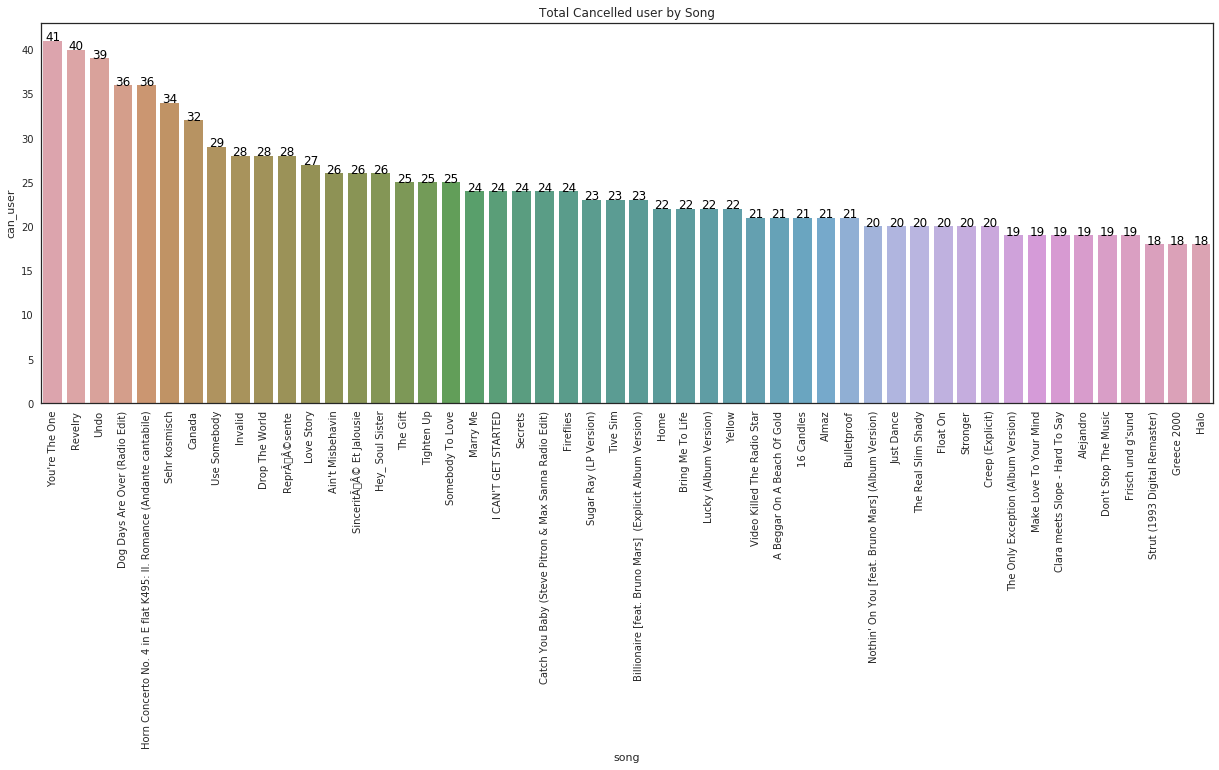

In [73]:
# Plot the df_song_c figures a graph
f, axes = plt.subplots(1, 1, figsize=(21, 7))

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_song_c, x='song', y='can_user', saturation=0.50);
ax1.set_title("Total Cancelled user by Song")

for i, row in df_song_c.iterrows():
   ax1.text(row.name, row.can_user, row.can_user, color='black', ha='center')

plt.xticks(rotation = 90)
plt.show();

In [74]:
%%cache df_song_d.plk df_song_d

# Find the song where most User downgraded

df_song_d = spark.sql( '''
SELECT a.song, count(distinct(a.userId)) as downgrade_user
  FROM log_table a
      ,log_table b
WHERE a.userId = b.userId
  AND a.page = 'NextSong'
  AND b.page = 'Downgrade'
GROUP by a.song
ORDER by 2 desc
LIMIT 50
''').toPandas()

[Saved variables 'df_song_d' to file '/home/workspace/df_song_d.plk'.]


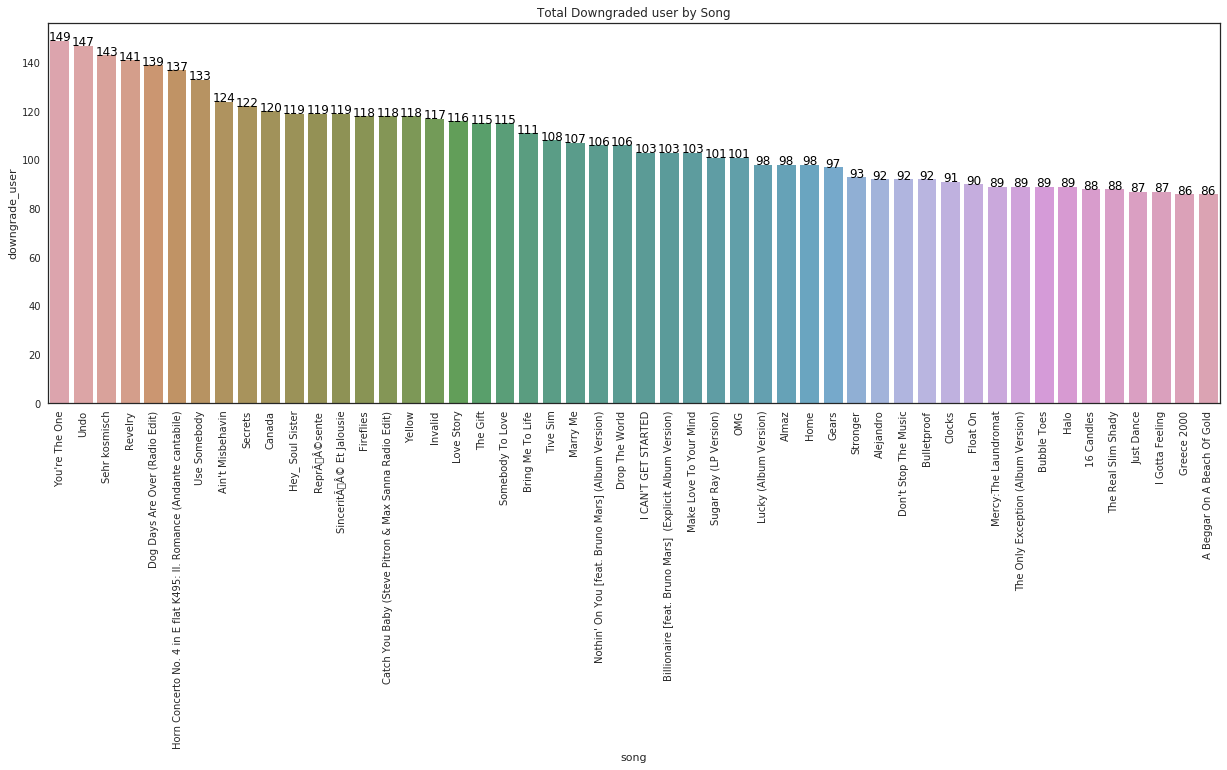

In [75]:
# Plot the df_song_d figures a graph
f, axes = plt.subplots(1, 1, figsize=(21, 7))

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_song_d, x='song', y='downgrade_user', saturation=0.50);
ax1.set_title("Total Downgraded user by Song")

for i, row in df_song_d.iterrows():
   ax1.text(row.name, row.downgrade_user, row.downgrade_user, color='black', ha='center')

plt.xticks(rotation = 90)
plt.show();

In [76]:
%%cache df_song_u.plk df_song_u

df_song_u = spark.sql( '''
SELECT a.song, count(distinct(a.userId)) as upgrade_user
  FROM log_table a
      ,log_table b
WHERE a.userId = b.userId
  AND a.page = 'NextSong'
  AND b.page = 'Upgrade'
GROUP by a.song
ORDER by 2 desc
LIMIT 50
''').toPandas()

[Saved variables 'df_song_u' to file '/home/workspace/df_song_u.plk'.]


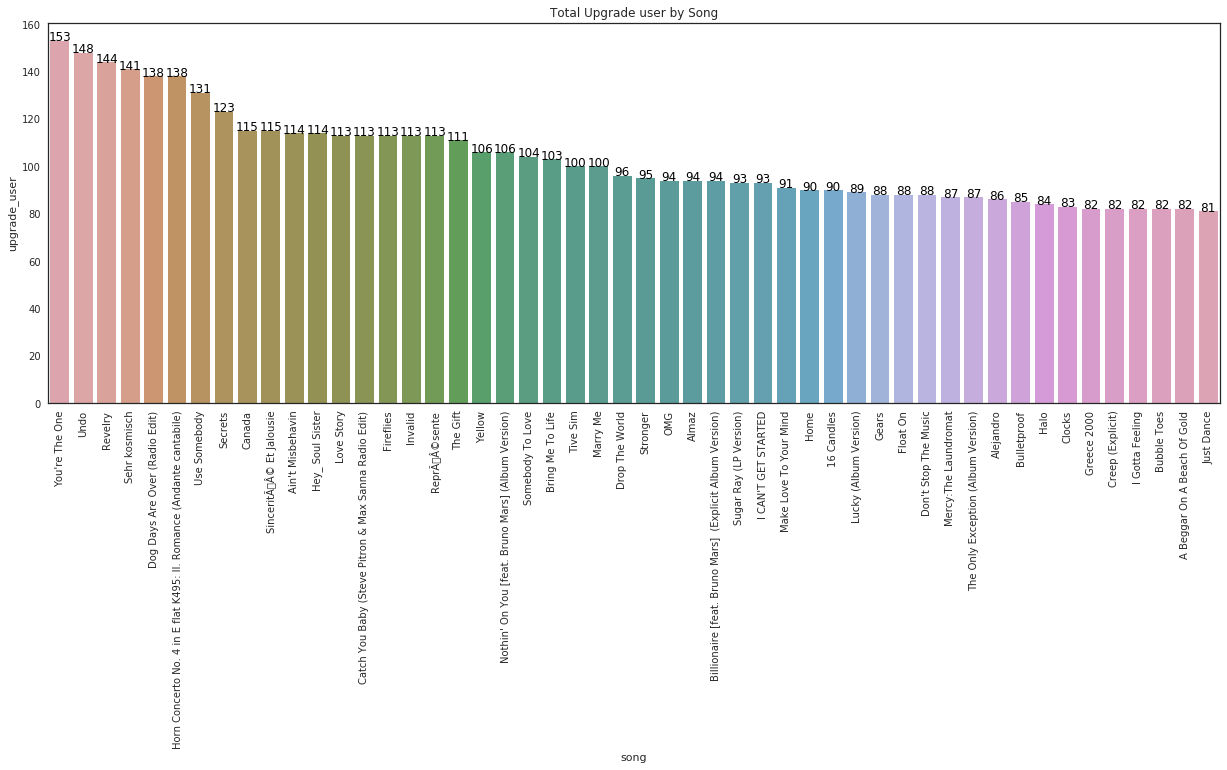

In [77]:
# Plot the df_song_c figures a graph
f, axes = plt.subplots(1, 1, figsize=(21, 7))

sbn.set(style="white", palette="muted", color_codes=True)

ax1 = sbn.barplot(data=df_song_u, x='song', y='upgrade_user', saturation=0.50);
ax1.set_title("Total Upgrade user by Song")

for i, row in df_song_u.iterrows():
   ax1.text(row.name, row.upgrade_user, row.upgrade_user, color='black', ha='center')

plt.xticks(rotation = 90)
plt.show();

We coud observe that first 4 song are same in all the 3 categories `Cancel`, `Upgrade` and `downgrade`. That is possible due to they could be most popular song for all users. Never the less different user have have listenend to diffent set of songs so we will have unique score for all the songs listen by the user.

We could generally observe that `cancelled users were more engaged with Sparkify` , `listening to more song`, `spending more time`, `more navigation`, `thumbs up`, `thumbs down`, `add friend` etc, than the active user. Perhaps the cancelled user have explored the Sparkify more that the existing active users and they could have cancelled as there is not much to explore further.

##### Let us analyse the how users `Browser` and `OS` of the device used contribute to `Cancel`, `Downgrade` and `Upgrade`

In [78]:
%%sparksql -l 100
SELECT DISTINCT(userAgent), page
  FROM log_t
 WHERE userAgent is NULL
  

userAgent,page
null,Home
null,About
null,Submit Registration
null,Login
null,Register
null,Help
null,Error


We could see that `userAgent` value is null for some of the pages,  if we use the null values we will end up with null OS and browsers for some of the records.  Let us check if every `userID` has atleast not null `userAgent` 

In [79]:
%%sparksql -l 100        
SELECT userID, userAgent
  FROM log_t
 WHERE userAgent is NULL 
 GROUP by userID
         ,userAgent

userID,userAgent
,null


There results there is no user without a userAgent. Let is get `userAgent` of every `userId` and use it to derive OS and browser of the user.

In [80]:
%%cache df_userAgent.plk df_userAgent

df_userAgent = df.filter('userAgent is not NULL') \
                 .groupBy('userId','userAgent')    \
                 .agg(col('userId'),col('userAgent')) \
                 .select('userID','userAgent')        \
                 .collect()

[Saved variables 'df_userAgent' to file '/home/workspace/df_userAgent.plk'.]


In [81]:
df_userAgent = spark.createDataFrame(df_userAgent)

In [82]:
df_userAgent.take(2)

[Row(userID='200021', userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userID='156', userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"')]

##### Define functions for extracing `OS` and `Browser` from the `userAgent` value

In [83]:
def findOS(s):
    '''
    Return the operating system string from the passed the string
    '''
    re1 = re.compile("\\((.*?)\\)")
    re_win = re.compile('Windows')
    re_mac = re.compile('Macintosh')
    re_comp = re.compile('compatible')
    re_X11  = re.compile('X11')
    re_ipad  = re.compile('iPad')
    re_iphone  = re.compile('iPhone')

    for os in re1.findall(s):   
         if re_mac.search(os):
             return os.split(';')[1].lstrip()
         elif re_ipad.search(os):
             return os.split(';')[1].lstrip()
         elif re_iphone.search(os):
             return os.split(';')[1].lstrip()
         elif re_comp.search(os):
            return os.split(';')[2].lstrip()
         elif re_win.search(os):
             return os.split(';')[0].lstrip()
         elif re_X11.search(os):
             return 'Ubuntu'

In [84]:
def findBrowser(s):
    '''
    Return the browser string from the passed the string
    '''
    if s != None:
         return s.split(' ')[-1].split(')')[0]
    else:
         return ' '

In [85]:
find_OS = udf(lambda x: findOS(str(x)), StringType())

In [86]:
find_Browser = udf(lambda x: findBrowser(str(x)), StringType())

In [87]:
#Create OS_ver and Browser_ver as new columns
df_userAgent = spark.createDataFrame(df_userAgent.withColumn('OS_Ver',find_OS('userAgent')) \
                                                 .withColumn('Browser_Ver', find_Browser('userAgent')) \
                                                 .collect() \
                                    )

In [88]:
df_userAgent.select('userId', 'OS_ver', 'Browser_Ver').show(10,False)

+------+---------------------------------+----------------+
|userId|OS_ver                           |Browser_Ver     |
+------+---------------------------------+----------------+
|200021|Intel Mac OS X 10.7              |Firefox/31.0    |
|156   |Windows NT 6.1                   |Safari/537.36"  |
|100010|CPU iPhone OS 7_1_2 like Mac OS X|Safari/9537.53" |
|7     |Windows NT 6.1                   |Firefox/31.0    |
|117   |Windows NT 6.1                   |Safari/537.36"  |
|150   |Intel Mac OS X 10_9_4            |Safari/537.36"  |
|100022|Intel Mac OS X 10.9              |Firefox/31.0    |
|300001|Windows NT 5.1                   |Safari/537.36"  |
|98    |Intel Mac OS X 10_9_4            |Safari/537.36"  |
|38    |Intel Mac OS X 10_9_4            |Safari/537.78.2"|
+------+---------------------------------+----------------+
only showing top 10 rows



Let us extract the OS and Browser values from `OS_ver` and `Browser_ver` columns

In [89]:
def findOSMain(s):
    '''
    Return the operating system string from the passed the string
    '''
    re_win = re.compile('Windows')
    re_mac = re.compile('Mac OS')
    re_ubuntu = re.compile('Ubuntu')

    if re_mac.search(s):
        return 'Macintosh'
    elif re_win.search(s):
        return 'Windows'
    elif re_ubuntu.search(s):
        return 'Ubuntu'
    else:
        return s

In [90]:
def findBrowserMain(s):
    '''
    Return the browser string from the passed the string
    '''
    re_firefox = re.compile('Firefox')
    re_Safari  = re.compile('Safari')
    re_Gecko   = re.compile('Gecko')
    re_Trident = re.compile('Trident')
    
    if re_firefox.search(s):
        return 'Firefox'
    elif re_Safari.search(s):
        return 'Safari'
    elif re_Gecko.search(s):
        return 'Firefox'
    elif re_Trident.search(s):
        return 'Trident'
    else:
         return s

In [91]:
find_Main_OS = udf(lambda x: findOSMain(str(x)), StringType())

In [92]:
find_Main_Browser = udf(lambda x: findBrowserMain(str(x)), StringType())

In [93]:
#Create OS and Browser as new columns
df_userAgent = spark.createDataFrame(df_userAgent.withColumn('OS',find_Main_OS('OS_ver')) \
                                                 .withColumn('Browser', find_Main_Browser('Browser_Ver')) \
                                                 .collect() \
                                    )

In [94]:
# Add browser OS cominations as columns to df_userAgent
concatOSBrowser = udf(lambda x,y : str(x) + '-' + str(y), StringType())

In [95]:
df_userAgent = df_userAgent.withColumn('OSBrowser',concatOSBrowser(col('OS'), col('Browser'))).collect()

In [96]:
df_userAgent = spark.createDataFrame(df_userAgent)

In [97]:
df_userAgent.select('userId', 'OS', 'OS_ver', 'Browser', 'Browser_Ver', 'OSBrowser').show(10,False)

+------+---------+---------------------------------+-------+----------------+-----------------+
|userId|OS       |OS_ver                           |Browser|Browser_Ver     |OSBrowser        |
+------+---------+---------------------------------+-------+----------------+-----------------+
|200021|Macintosh|Intel Mac OS X 10.7              |Firefox|Firefox/31.0    |Macintosh-Firefox|
|156   |Windows  |Windows NT 6.1                   |Safari |Safari/537.36"  |Windows-Safari   |
|100010|Macintosh|CPU iPhone OS 7_1_2 like Mac OS X|Safari |Safari/9537.53" |Macintosh-Safari |
|7     |Windows  |Windows NT 6.1                   |Firefox|Firefox/31.0    |Windows-Firefox  |
|117   |Windows  |Windows NT 6.1                   |Safari |Safari/537.36"  |Windows-Safari   |
|150   |Macintosh|Intel Mac OS X 10_9_4            |Safari |Safari/537.36"  |Macintosh-Safari |
|100022|Macintosh|Intel Mac OS X 10.9              |Firefox|Firefox/31.0    |Macintosh-Firefox|
|300001|Windows  |Windows NT 5.1        

In [98]:
df_userAgent.createOrReplaceTempView("UserAgent_t")

In [99]:
%%sparksql -l 100
SELECT DISTINCT(OS)
  FROM UserAgent_t
 ORDER BY 1

OS
Macintosh
Ubuntu
Windows


In [100]:
%%sparksql -l 100
SELECT DISTINCT(Browser)
  FROM UserAgent_t
 ORDER BY 1

Browser
Firefox
Safari
Trident


In [101]:
%%sparksql -l 100
SELECT DISTINCT(OSBrowser)
  FROM UserAgent_t
 ORDER BY 1

OSBrowser
Macintosh-Firefox
Macintosh-Safari
Ubuntu-Firefox
Ubuntu-Safari
Windows-Firefox
Windows-Safari
Windows-Trident


Join the the `df` dataframe and `df_userAgent` dataframe on UserId to merge in OS and Browse fields to main dataframe
Recreate `Log_t` table with `OS and Browser` columns for further data Analysis

In [102]:
temp_list = df.alias('m').join(df_userAgent.alias('n'), col('m.userId') == col('n.userId'))  \
             .select([col('m.'+xx) for xx in df.columns] + df_userAgent.columns[2:]) \
             .collect()

In [103]:
df = spark.createDataFrame(temp_list)

In [104]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- day: long (nullable = true)
 |-- OS_Ver: string (nullable = true)
 |-- Browser_Ver: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- OSBrowser: string (nullable = true)



In [105]:
df.createOrReplaceTempView("log_t")

##### Let us Analyse the `OS` and `Browser` on cancellation Upgrade and downgrades
######  Cancelled user by OS 

In [106]:
%%sparksql -l 100
-- cancelled user by OS
SELECT a.OS  as OS
      ,count(distinct(a.userId)) as can_user
  FROM log_t a
      ,log_t b
WHERE a.userId = b.userId
  AND b.page = 'Cancel'
GROUP by a.OS
ORDER by can_user DESC
LIMIT 50

OS,can_user
Windows,24
Macintosh,23
Ubuntu,5


###### OS user by cancelled user of the OS - this give us more sense of what OS is causing more cancellation 

In [107]:
%%sparksql -l 100

select MT.OS
      ,can_user
      ,OS_User
      ,OS_User / can_user as Can_user_per_OS
FROM    
    (SELECT a.OS  as OS
          ,count(distinct(a.userId)) as can_user
      FROM log_t a
          ,log_t b
    WHERE a.userId = b.userId
      AND b.page = 'Cancel'
    GROUP by a.OS
    ORDER by can_user DESC) CT

    ,(SELECT a.OS  as OS
          ,count(distinct(a.userId)) as OS_User
      FROM log_t a
     GROUP by a.OS
     ORDER by OS_user DESC) MT
    
WHERE 
    CT.OS = MT.OS
ORDER BY 3 DESC

OS,can_user,OS_User,Can_user_per_OS
Windows,24,111,4.625
Macintosh,23,102,4.434782608695652
Ubuntu,5,12,2.4


We could observer that `Windows` OS has most per user cancellation

###### Cancelled User by Browser

In [108]:
%%sparksql -l 100
-- cancelled user by Browser
SELECT a.Browser  as Browser
      ,count(distinct(a.userId)) as can_user
  FROM log_t a
      ,log_t b
WHERE a.userId = b.userId
  AND b.page = 'Cancel'
GROUP by a.Browser
ORDER by can_user DESC
LIMIT 50

Browser,can_user
Safari,35
Firefox,17


###### Broswser user by cancelled user of the Browser - this give us more sense of what Browser is causing more cancellation 

In [109]:
%%sparksql -l 100
select MT.Browser
      ,can_user
      ,Browser_User
      ,Browser_User / can_user as Can_user_per_Browser
FROM    
    (SELECT a.Browser  as Browser
          ,count(distinct(a.userId)) as can_user
      FROM log_t a
          ,log_t b
    WHERE a.userId = b.userId
      AND b.page = 'Cancel'
    GROUP by a.Browser
    ORDER by can_user DESC) CT

    ,(SELECT a.Browser  as Browser
          ,count(distinct(a.userId)) as Browser_User
      FROM log_t a
     GROUP by a.Browser
     ORDER by Browser_User DESC) MT
    
WHERE 
    CT.Browser = MT.Browser
ORDER BY 3 DESC

Browser,can_user,Browser_User,Can_user_per_Browser
Safari,35,163,4.6571428571428575
Firefox,17,57,3.3529411764705883


We could observer that `Safari` Browers `Cancelled` more per user.  Let is see the effect of combination of `OS` and `Browser`
###### Cancelled users OS Browser combination

In [110]:
%%sparksql -l 100

SELECT OSBrowser
      ,COUNT(distinct(userId)) as OS_Browser_user
  FROM log_t 
 GROUP by OSBrowser
 ORDER by OS_Browser_user DESC

OSBrowser,OS_Browser_user
Macintosh-Safari,89
Windows-Safari,68
Windows-Firefox,38
Macintosh-Firefox,13
Ubuntu-Firefox,6
Ubuntu-Safari,6
Windows-Trident,5


######  Cancelled user of the OS-Browser comination by number of users with OS-Browser Combination - This give us more sense of what OS-Browser is causing more cancellation

In [111]:
%%cache df_OSBrowser_c.plk df_OSBrowser_c

df_OSBrowser_c = spark.sql(
'''
SELECT T1.OSBrowser
      ,OS_Browser_Can_user
      ,OS_Browser_user
      ,OS_Browser_user / OS_Browser_Can_user as Can_user_per_OSBrowser
FROM 

    (SELECT MT.OSBrowser as OSBrowser
          ,COUNT(distinct(MT.userId)) as OS_Browser_Can_user
      FROM loG_t MT
          ,log_t CT
     WHERE MT.userId = CT.userId
       AND CT.page = 'Cancel'
     GROUP by 
           MT.OSBrowser
     ORDER by 
           OS_Browser_Can_user DESC
    )  T1


   ,(SELECT OSBrowser
          ,COUNT(distinct(userId)) as OS_Browser_user
      FROM log_t
     GROUP BY
           OSBrowser
     ORDER by 
           OS_Browser_user DESC
    ) T2

WHERE
    T1.OSBrowser = T2.OSBrowser 
ORDER BY 
    Can_user_per_OSBrowser DESC
''').toPandas()

[Saved variables 'df_OSBrowser_c' to file '/home/workspace/df_OSBrowser_c.plk'.]


In [112]:
df_OSBrowser_c.style.hide_index()

OSBrowser,OS_Browser_Can_user,OS_Browser_user,Can_user_per_OSBrowser
Ubuntu-Safari,1,6,6
Windows-Safari,14,68,4.85714
Macintosh-Safari,20,89,4.45
Macintosh-Firefox,3,13,4.33333
Windows-Firefox,10,38,3.8
Ubuntu-Firefox,4,6,1.5


We could see a clear tread of cancellation of Browser OS combination

##### Let us observe the Propartion of users  for  Upgrades

In [113]:
%%cache df_OSBrowser_u.plk df_OSBrowser_u

df_OSBrowser_u = spark.sql(
'''
SELECT T1.OSBrowser
      ,OS_Browser_Upgrade_user
      ,OS_Browser_user
      ,OS_Browser_user / OS_Browser_Upgrade_user as Upgrade_user_per_OSBrowser
FROM 

    (SELECT MT.OSBrowser as OSBrowser
          ,COUNT(distinct(MT.userId)) as OS_Browser_Upgrade_user
      FROM loG_t MT
          ,log_t CT
     WHERE MT.userId = CT.userId
       AND CT.page = 'Upgrade'
     GROUP by 
           MT.OSBrowser
     ORDER by 
           OS_Browser_Upgrade_user DESC
    )  T1


   ,(SELECT OSBrowser
          ,COUNT(distinct(userId)) as OS_Browser_user
      FROM log_t
     GROUP BY
           OSBrowser
     ORDER by 
           OS_Browser_user DESC
    ) T2

WHERE
    T1.OSBrowser = T2.OSBrowser 
ORDER BY 
    Upgrade_user_per_OSBrowser DESC
''').toPandas()

[Saved variables 'df_OSBrowser_u' to file '/home/workspace/df_OSBrowser_u.plk'.]


In [114]:
df_OSBrowser_u.style.hide_index()

OSBrowser,OS_Browser_Upgrade_user,OS_Browser_user,Upgrade_user_per_OSBrowser
Ubuntu-Safari,1,6,6
Macintosh-Firefox,9,13,1.44444
Windows-Firefox,28,38,1.35714
Macintosh-Safari,68,89,1.30882
Windows-Safari,53,68,1.28302
Windows-Trident,4,5,1.25
Ubuntu-Firefox,5,6,1.2


We could observe the `Ubuntu-safari` followed by `Macintosh-Firefox` are most cancelled

##### Let us observe the Propartion of users  for  Downgrade

In [115]:
%%cache df_OSBrowser_d.plk df_OSBrowser_d

df_OSBrowser_d = spark.sql(
'''
SELECT T1.OSBrowser
      ,OS_Browser_Downgrade_user
      ,OS_Browser_user
      ,OS_Browser_user / OS_Browser_Downgrade_user as Downgrade_user_per_OSBrowser
FROM 

    (SELECT MT.OSBrowser as OSBrowser
          ,COUNT(distinct(MT.userId)) as OS_Browser_Downgrade_user
      FROM loG_t MT
          ,log_t CT
     WHERE MT.userId = CT.userId
       AND CT.page = 'Downgrade'
     GROUP by 
           MT.OSBrowser
     ORDER by 
           OS_Browser_Downgrade_user DESC
    )  T1


   ,(SELECT OSBrowser
          ,COUNT(distinct(userId)) as OS_Browser_user
      FROM log_t
     GROUP BY
           OSBrowser
     ORDER by 
           OS_Browser_user DESC
    ) T2

WHERE
    T1.OSBrowser = T2.OSBrowser 
ORDER BY 
    Downgrade_user_per_OSBrowser DESC
''').toPandas()

[Saved variables 'df_OSBrowser_d' to file '/home/workspace/df_OSBrowser_d.plk'.]


In [116]:
df_OSBrowser_d.style.hide_index()

OSBrowser,OS_Browser_Downgrade_user,OS_Browser_user,Downgrade_user_per_OSBrowser
Ubuntu-Firefox,3,6,2
Macintosh-Safari,54,89,1.64815
Macintosh-Firefox,9,13,1.44444
Windows-Firefox,27,38,1.40741
Windows-Safari,50,68,1.36
Ubuntu-Safari,6,6,1
Windows-Trident,5,5,1


###### Plot the Cancel, Downgrade, Upgrade per user of OS-Browser combination

In [117]:
df_osbrowser = df_OSBrowser_d[['OSBrowser','Downgrade_user_per_OSBrowser']]         \
                .merge(df_OSBrowser_u[['OSBrowser','Upgrade_user_per_OSBrowser']],  \
                       how='outer',                                                 \
                       suffixes='_d')                                               \
                .merge(df_OSBrowser_c[['OSBrowser','Can_user_per_OSBrowser']],      \
                       how='outer',                                                 \
                       suffixes='_c')                                               \
                .fillna(0)

In [118]:
df_osbrowser

,OSBrowser,Downgrade_user_per_OSBrowser,Upgrade_user_per_OSBrowser,Can_user_per_OSBrowser
0,Ubuntu-Firefox,2.000000,1.200000,1.500000
1,Macintosh-Safari,1.648148,1.308824,4.450000
2,Macintosh-Firefox,1.444444,1.444444,4.333333
3,Windows-Firefox,1.407407,1.357143,3.800000
4,Windows-Safari,1.360000,1.283019,4.857143
5,Ubuntu-Safari,1.000000,6.000000,6.000000
6,Windows-Trident,1.000000,1.250000,0.000000


In [119]:
df_osbrowser = pd.melt(df_osbrowser, 
                       id_vars=['OSBrowser'], 
                       value_vars=['Can_user_per_OSBrowser',
                                   'Downgrade_user_per_OSBrowser',
                                   'Upgrade_user_per_OSBrowser'])


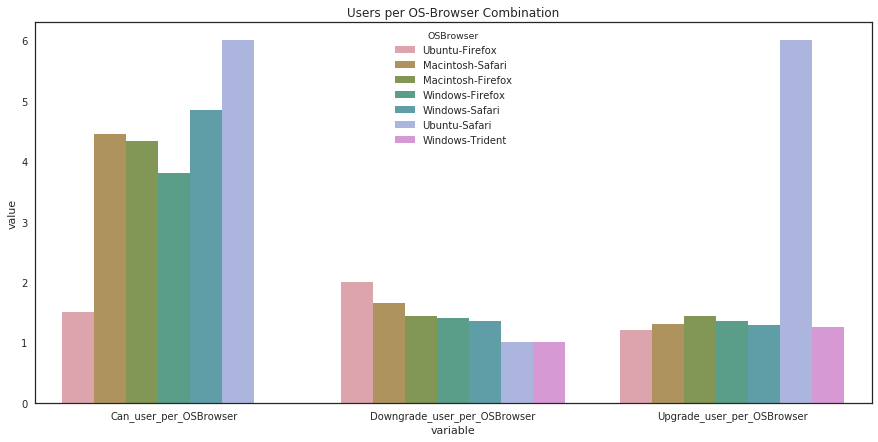

In [120]:
f, axes = plt.subplots(1, 1, figsize=(15, 7))

ax1 = sbn.barplot(data=df_osbrowser,
            x='variable', 
            y='value',
            hue='OSBrowser',
            saturation=0.50);

ax1.set_title("Users per OS-Browser Combination")
plt.show();

We could see that , there are more `cancellation` in `Ubuntu-Safari` combination. `Windows-Trident` combination has least `Downgrades`.  As we could see there is quite a variation on `OS-Browser` combination this can be used as features.

We are ready to extract the features and build model to predict `churn`

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the Data Exploration Analysis done so far I can think of these feature `per user` basis. There are `numerical` features and numeric encoded `categorical` features.

#### Numerical features
> * Listening time in minitues   - representing Time spent in listening to songs 
> * Number of sessions - How often user logoff and logged 
> * Number of items in session  - How much user was navigating daily
> * Number of songs - Number of song user listen,  this is different for how long because use could just play few minutes of the song and skip to nextsong
> * Number of thumbs up
> * Number of thumbs downs
> * Number of upgrades
> * Number of roll adverts
> * Number of downgrades
> * Number of add friends
> * Number of add to playlist
> * Number of distinct artist
> * Number of distinct songs
> * Sum of Rank of all songs listen by cancelled user - total number of user cancelled on that day and also were listenting to that song
> * Sum of rank of all songs listen by downgrade user - total number of user downgradred on that day and also were listenting to that song
> * Length of time between upgrade and cancellation - This will be 0 for user who has not cancelled 
> * Lenght of time between downgrades - this will be 0 for user who are free or user how have not downgraded.  This will be different for different downgrade period for same user
> * Lenght of time between last downgrade and cancellation - This will be 0 if not downgraded and cancelled, this will be actual lenght of time between downgrade and cancel in days.

At the end of the feature engineering we will have 1 feature vector `Per user` of data in the dataset and label users as `1` if `active` and `0` if `Cancel`led

#### Numerical Features extraction

In [121]:
%%cache df_1.plk df_1

# Create column isCancelled to as label columns for cancalled user

df_1 = spark.sql('''
SELECT *
  FROM (
    SELECT a.*
           ,1 as isCancelled
      FROM log_t a
          ,log_t b
      WHERE a.userId = b.userId
        and b.page = 'Cancel'
        and a.userId <> ''
    --
      UNION ALL
    --
    SELECT *
           ,0 as isCancelled
      FROM log_t a 
     WHERE a.userId not in
           ( 
               SELECT distinct(b.userId)
                 FROM log_t b
                 WHERE b.page = 'Cancel'
                   and b.userId <> ''
           )
       and a.userId <> ''
      ) a
ORDER BY ts
''').collect()

[Saved variables 'df_1' to file '/home/workspace/df_1.plk'.]


In [122]:
df = spark.createDataFrame(df_1)
del df_1

In [123]:
df.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, day: bigint, OS_Ver: string, Browser_Ver: string, OS: string, Browser: string, OSBrowser: string, isCancelled: bigint]

In [124]:
df.createOrReplaceTempView("log_t")

In [125]:
%%cache cancelledUserCount.plk cancelledUserCount

cancelledUserCount = spark.sql('''
SELECT count(distinct(userId)) as cancelledUserCount
FROM log_t
WHERE isCancelled = 1
'''
).toPandas()

[Saved variables 'cancelledUserCount' to file '/home/workspace/cancelledUserCount.plk'.]


In [126]:
cancelledUserCount.style.hide_index()

cancelledUserCount
52


In [127]:
%%sparksql 

SELECT count(distinct(userId)) cancelledUserCount
FROM log_t
WHERE page = 'Cancel'

cancelledUserCount
52


We could see the `count of cancelled users` and `count of isCancelled user` `are same`, which indicates the isCancelled label is applied to all cancelled users

##### Start creating a dataframe with feature with label column `isCancelled`

In [128]:
%%cache f0.plk f0

f0 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,isCancelled
  FROM log_t 
GROUP BY
    userId
    ,isCancelled
ORDER BY
    userId
''').collect()

[Saved variables 'f0' to file '/home/workspace/f0.plk'.]


In [129]:
features = spark.createDataFrame(f0)
features.select('userId','isCancelled').show(10)

+------+-----------+
|userId|isCancelled|
+------+-----------+
|    10|          0|
|   100|          0|
|100001|          1|
|100002|          0|
|100003|          1|
|100004|          0|
|100005|          1|
|100006|          1|
|100007|          1|
|100008|          0|
+------+-----------+
only showing top 10 rows



In [130]:
features.count()

225

###### Feature `#1` Daily listening time in minitues   - representing Time spent in listening to songs 

In [131]:
%%cache f1.plk f1

f1 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,sum(length) as listenTime
FROM log_t
GROUP BY
    userId
ORDER BY    
    userId
''').collect()

[Saved variables 'f1' to file '/home/workspace/f1.plk'.]


In [132]:
features = features.join(spark.createDataFrame(f1), on=['userId'], how='left').na.fill({'listenTime':0})

In [133]:
features.select('userId','isCancelled','listenTime').show(10)

+------+-----------+------------------+
|userId|isCancelled|        listenTime|
+------+-----------+------------------+
|100010|          0| 66940.89735000003|
|200002|          0| 94008.87593999993|
|   125|          1|2089.1131000000005|
|   124|          0|1012312.0927899999|
|    51|          1| 523275.8428000004|
|     7|          0| 38034.08710000002|
|    15|          0|477307.60581000015|
|    54|          1| 711344.9195400011|
|   155|          0|       198779.2919|
|100014|          1| 67703.47208000004|
+------+-----------+------------------+
only showing top 10 rows



##### Feature `#2` Number of sessions - How often user logoff and logged

In [134]:
%%cache f2.plk f2

f2 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(distinct(sessionId)) as sessions
FROM log_t
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f2' to file '/home/workspace/f2.plk'.]


In [135]:
features = features.join(spark.createDataFrame(f2), on=['userId'], how='left').na.fill({'sessions':0})

In [136]:
features.select('userId','isCancelled','sessions').show(10)

+------+-----------+--------+
|userId|isCancelled|sessions|
+------+-----------+--------+
|100010|          0|       7|
|200002|          0|       6|
|   125|          1|       1|
|   124|          0|      29|
|    51|          1|      10|
|     7|          0|       7|
|    15|          0|      15|
|    54|          1|      37|
|   155|          0|       6|
|100014|          1|       6|
+------+-----------+--------+
only showing top 10 rows



##### Feature `#3`  number of items in session  - How much user was navigating

In [137]:
%%cache f3.plk f3

f3 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(itemInSession) as numOfItems
FROM log_t
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f3' to file '/home/workspace/f3.plk'.]


In [138]:
features = features.join(spark.createDataFrame(f3), on=['userId'], how='left').na.fill({'numOfItems':0})

In [139]:
features.select('userId','isCancelled','numOfItems').show(10)

+------+-----------+----------+
|userId|isCancelled|numOfItems|
+------+-----------+----------+
|100010|          0|       381|
|200002|          0|       474|
|   125|          1|        11|
|   124|          0|      4825|
|    51|          1|      2464|
|     7|          0|       201|
|    15|          0|      2278|
|    54|          1|      3437|
|   155|          0|      1002|
|100014|          1|       310|
+------+-----------+----------+
only showing top 10 rows



##### Feature `#4` Number of songs listened  -  This is different from length of listening because user could just play few minutes of the song and skip to nextsong

In [140]:
%%cache f4.plk f4

f4 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(itemInSession) as numOfSongs
FROM log_t
where page = 'NextSong'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f4' to file '/home/workspace/f4.plk'.]


In [141]:
features = features.join(spark.createDataFrame(f4), on=['userId'], how='left').na.fill({'numOfSongs':0})

In [142]:
features.select('userId','isCancelled','numOfSongs').show(10)

+------+-----------+----------+
|userId|isCancelled|numOfSongs|
+------+-----------+----------+
|100010|          0|       275|
|200002|          0|       387|
|   125|          1|         8|
|   124|          0|      4079|
|    51|          1|      2111|
|     7|          0|       150|
|    15|          0|      1914|
|    54|          1|      2841|
|   155|          0|       820|
|100014|          1|       257|
+------+-----------+----------+
only showing top 10 rows



##### Feature `#5`  Number of thumbs up

In [143]:
%%cache f5.plk f5

f5 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,coalesce(count(page),0) as thumbsUp
FROM log_t
WHERE page = 'Thumbs Up'
GROUP BY    
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f5' to file '/home/workspace/f5.plk'.]


In [144]:
features = features.join(spark.createDataFrame(f5), on=['userId'], how='left').na.fill({'thumbsUp':0})

In [145]:
features.select('userId','isCancelled','thumbsUp').show(10)

+------+-----------+--------+
|userId|isCancelled|thumbsUp|
+------+-----------+--------+
|100010|          0|      17|
|200002|          0|      21|
|   125|          1|       0|
|   124|          0|     171|
|    51|          1|     100|
|     7|          0|       7|
|    15|          0|      81|
|    54|          1|     163|
|   155|          0|      58|
|100014|          1|      17|
+------+-----------+--------+
only showing top 10 rows



##### Feature `#6`  Number of Thumbs Down

In [146]:
%%cache f6.plk f6

f6 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(page) as thumbsDown
FROM log_t
WHERE page = 'Thumbs Down'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f6' to file '/home/workspace/f6.plk'.]


In [147]:
features = features.join(spark.createDataFrame(f6), on=['userId'], how='left').na.fill({'thumbsDown':0})

In [148]:
features.select('userId','isCancelled','thumbsDown').show(10)

+------+-----------+----------+
|userId|isCancelled|thumbsDown|
+------+-----------+----------+
|100010|          0|         5|
|200002|          0|         6|
|   125|          1|         0|
|   124|          0|        41|
|    51|          1|        21|
|     7|          0|         1|
|    15|          0|        14|
|    54|          1|        29|
|   155|          0|         3|
|100014|          1|         3|
+------+-----------+----------+
only showing top 10 rows



##### Feature `#7`  Number of upgrades

In [149]:
%%cache f7.plk f7

f7 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(page) as upgrade
FROM log_t
WHERE page = 'Upgrade'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f7' to file '/home/workspace/f7.plk'.]


In [150]:
features = features.join(spark.createDataFrame(f7), on=['userId'], how='left').na.fill({'upgrade':0})

In [151]:
features.select('userId','isCancelled','upgrade').show(10)

+------+-----------+-------+
|userId|isCancelled|upgrade|
+------+-----------+-------+
|100010|          0|      2|
|200002|          0|      2|
|   125|          1|      0|
|   124|          0|      0|
|    51|          1|      0|
|     7|          0|      2|
|    15|          0|      0|
|    54|          1|      1|
|   155|          0|      2|
|100014|          1|      0|
+------+-----------+-------+
only showing top 10 rows



##### Feature `#8`  Number of  Adverts rolls

In [152]:
%%cache f8.plk f8

f8 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(page) as rollAdvert
FROM log_t
WHERE page = 'Roll Advert'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f8' to file '/home/workspace/f8.plk'.]


In [153]:
features = features.join(spark.createDataFrame(f8), on=['userId'], how='left').na.fill({'rollAdvert':0})

In [154]:
features.select('userId','isCancelled','rollAdvert').show(10)

+------+-----------+----------+
|userId|isCancelled|rollAdvert|
+------+-----------+----------+
|100010|          0|        52|
|200002|          0|         7|
|   125|          1|         1|
|   124|          0|         4|
|    51|          1|         0|
|     7|          0|        16|
|    15|          0|         1|
|    54|          1|        47|
|   155|          0|         8|
|100014|          1|         2|
+------+-----------+----------+
only showing top 10 rows



##### Feature `#9`  Roll Adverts in seconds per user

In [155]:
%%cache f9.plk f9

f9 = spark.sql('''
SELECT a.userId
      ,CASE 
       WHEN sum(next_ts - a.ts) < 0 THEN
            0
       ELSE 
            sum(next_ts - a.ts) 
       END as advert_seconds
FROM (
    SELECT 
        DISTINCT(userId) as userId
        ,day
        ,page
        ,ts/1000 as ts
        ,LEAD(ts/1000,1,0)
            OVER ( PARTITION BY userId, day
                       ORDER BY userId, day, ts
                 ) as next_ts 
    FROM log_t
   GROUP BY 
        userId
        ,day
        ,page
        ,ts
  ORDER BY
        userId
        ,day
        ,ts
  ) a
WHERE 
    a.page = 'Roll Advert'
GROUP BY 
    a.userId
ORDER BY 
    a.userId
''').collect()

[Saved variables 'f9' to file '/home/workspace/f9.plk'.]


In [156]:
features = features.join(spark.createDataFrame(f9), on=['userId'], how='left').na.fill({'advert_seconds':0})

In [157]:
features.select('userId','isCancelled','advert_seconds').show(10)

+------+-----------+--------------+
|userId|isCancelled|advert_seconds|
+------+-----------+--------------+
|100010|          0|           0.0|
|200002|          0|           0.0|
|   125|          1|           1.0|
|   124|          0|         548.0|
|    51|          1|           0.0|
|     7|          0|           0.0|
|    15|          0|         132.0|
|    54|          1|           0.0|
|   155|          0|        1666.0|
|100014|          1|         411.0|
+------+-----------+--------------+
only showing top 10 rows



##### Feature `#10`  Number of downgrades per user

In [158]:
%%cache f10.plk f10

f10 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(page) as downgrade
FROM log_t
WHERE page = 'Downgrade'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f10' to file '/home/workspace/f10.plk'.]


In [159]:
features = features.join(spark.createDataFrame(f10), on=['userId'], how='left').na.fill({'downgrade':0})

In [160]:
features.select('userId','isCancelled','downgrade').show(10)

+------+-----------+---------+
|userId|isCancelled|downgrade|
+------+-----------+---------+
|100010|          0|        0|
|200002|          0|        5|
|   125|          1|        0|
|   124|          0|       41|
|    51|          1|       23|
|     7|          0|        0|
|    15|          0|       28|
|    54|          1|       39|
|   155|          0|       12|
|100014|          1|        3|
+------+-----------+---------+
only showing top 10 rows



##### Feature `#11`  Number of add friends event per user

In [161]:
%%cache f11.plk f11

f11 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(page) as addFriend
FROM log_t
WHERE page = 'Add Friend'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f11' to file '/home/workspace/f11.plk'.]


In [162]:
features = features.join(spark.createDataFrame(f11), on=['userId'], how='left').na.fill({'addFriend':0})

In [163]:
features.select('userId','isCancelled','addFriend').show(10)

+------+-----------+---------+
|userId|isCancelled|addFriend|
+------+-----------+---------+
|100010|          0|        4|
|200002|          0|        4|
|   125|          1|        0|
|   124|          0|       74|
|    51|          1|       28|
|     7|          0|        1|
|    15|          0|       31|
|    54|          1|       33|
|   155|          0|       11|
|100014|          1|        6|
+------+-----------+---------+
only showing top 10 rows



##### Feature `#12`  Number of add to playlist event per user

In [164]:
%%cache f12.plk f12

f12 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(page) as addToPlaylist
FROM log_t
WHERE page = 'Add to Playlist'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f12' to file '/home/workspace/f12.plk'.]


In [165]:
features = features.join(spark.createDataFrame(f12), on=['userId'], how='left').na.fill({'addToPlaylist':0})

In [166]:
features.select('userId','isCancelled','addToPlaylist').show(10)

+------+-----------+-------------+
|userId|isCancelled|addToPlaylist|
+------+-----------+-------------+
|100010|          0|            7|
|200002|          0|            8|
|   125|          1|            0|
|   124|          0|          118|
|    51|          1|           52|
|     7|          0|            5|
|    15|          0|           59|
|    54|          1|           72|
|   155|          0|           24|
|100014|          1|            7|
+------+-----------+-------------+
only showing top 10 rows



##### Feature `#13`  Number of distinct Artists per user

In [167]:
%%cache f13.plk f13

f13 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(distinct artist) as numOfArtist
FROM log_t
WHERE artist is not null
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f13' to file '/home/workspace/f13.plk'.]


In [168]:
features = features.join(spark.createDataFrame(f13), on=['userId'], how='left').na.fill({'numOfArtist':0})

In [169]:
features.select('userId','isCancelled','numOfArtist').show(10)

+------+-----------+-----------+
|userId|isCancelled|numOfArtist|
+------+-----------+-----------+
|100010|          0|        252|
|200002|          0|        339|
|   125|          1|          8|
|   124|          0|       2232|
|    51|          1|       1385|
|     7|          0|        142|
|    15|          0|       1302|
|    54|          1|       1744|
|   155|          0|        643|
|100014|          1|        233|
+------+-----------+-----------+
only showing top 10 rows



##### Feature `#14`  Number of distinct songs

In [170]:
%%cache f14.plk f14

f14 = spark.sql('''
SELECT 
    distinct(userId) as userId
    ,count(distinct song) as numOfUniqSongs
FROM log_t
WHERE song is not null
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f14' to file '/home/workspace/f14.plk'.]


In [171]:
features = features.join(spark.createDataFrame(f14), on=['userId'], how='left').na.fill({'numOfUniqSongs':0})

In [172]:
features.select('userId','isCancelled','numOfUniqSongs').show(10)

+------+-----------+--------------+
|userId|isCancelled|numOfUniqSongs|
+------+-----------+--------------+
|100010|          0|           269|
|200002|          0|           378|
|   125|          1|             8|
|   124|          0|          3339|
|    51|          1|          1854|
|     7|          0|           148|
|    15|          0|          1707|
|    54|          1|          2414|
|   155|          0|           759|
|100014|          1|           248|
+------+-----------+--------------+
only showing top 10 rows



##### Feature `#15`  Sum of  Rank of a song listen by User.  -ve rank is given to have the low rank like 1 have higher value -1 than rank 25 which will be -25 lower than the -1 

In [173]:
%%cache f15.plk f15

f15 = spark.sql('''
SELECT x.userId
     , sum(y.songRank) as sumSongRank
FROM log_t x
    ,(SELECT t.day
         , t.song
         , rank() OVER( PARTITION BY t.day, t.song
                        ORDER BY t.day, t.song
                      ) * -1 AS songRank
    FROM
        (
        SELECT a.day
            , a.song
            , count(a.song) AS songCount 
        FROM log_t a
        WHERE a.song is not null
        GROUP BY a.day
                 ,a.song
        ORDER BY a.day
                 ,songCount DESC    
        ) T
    GROUP BY t.day
            ,t.song
    ORDER BY t.day
            ,songRank
    ) y
WHERE x.day = y.day
  AND X.song = y.song
GROUP BY 
      x.userId
ORDER BY     
      x.userId
''').collect()

[Saved variables 'f15' to file '/home/workspace/f15.plk'.]


In [174]:
features = features.join(spark.createDataFrame(f15), on=['userId'], how='left').na.fill({'sumSongRank':0})

In [175]:
features.select('userId','isCancelled','sumSongRank').show(10)

+------+-----------+-----------+
|userId|isCancelled|sumSongRank|
+------+-----------+-----------+
|100010|          0|       -275|
|200002|          0|       -387|
|   125|          1|         -8|
|   124|          0|      -4079|
|    51|          1|      -2111|
|     7|          0|       -150|
|    15|          0|      -1914|
|    54|          1|      -2841|
|   155|          0|       -820|
|100014|          1|       -257|
+------+-----------+-----------+
only showing top 10 rows



##### Feature `#16`  Sum of  Rank of Artist's songs listen by User .  -ve rank is given to have the low rank like 1 have higher value -1 than rank 25 which will be -25 lower than the -1 

In [176]:
%%cache f16.plk f16

f16 = spark.sql('''
SELECT x.userId
    , sum(y.artistRank) as sumArtistRank
FROM log_t x
    ,(SELECT t.day
         , t.artist
         , rank() OVER( PARTITION BY t.day, t.artist
                        ORDER BY t.day, t.artist
                      ) * -1 AS artistRank
    FROM
        (
        SELECT a.day
            , a.artist
            , count(a.artist) AS artistCount 
        FROM log_t a
        WHERE a.artist is not null
        GROUP BY a.day
                 ,a.artist
        ORDER BY a.day
                 ,artistCount DESC    
        ) T
    GROUP BY t.day
            ,t.artist
    ORDER BY t.day
            ,artistRank
    ) y
WHERE x.day = y.day
  AND X.artist = y.artist
GROUP BY 
      x.userId
ORDER BY     
      x.userId
''').collect()

[Saved variables 'f16' to file '/home/workspace/f16.plk'.]


In [177]:
features = features.join(spark.createDataFrame(f16), on=['userId'], how='left').na.fill({'sumArtistRank':0})

In [178]:
features.select('userId','isCancelled','sumArtistRank').show(10)

+------+-----------+-------------+
|userId|isCancelled|sumArtistRank|
+------+-----------+-------------+
|100010|          0|         -275|
|200002|          0|         -387|
|   125|          1|           -8|
|   124|          0|        -4079|
|    51|          1|        -2111|
|     7|          0|         -150|
|    15|          0|        -1914|
|    54|          1|        -2841|
|   155|          0|         -820|
|100014|          1|         -257|
+------+-----------+-------------+
only showing top 10 rows



##### Feature `#17`  Number of days from Upgrade to Cancel. For user who not cancelled this value will be zero

In [179]:
%%cache f17.plk f17

f17 = spark.sql('''
SELECT a.userId
      ,(max(b.ts) - min(a.ts))/(60*60*24*1000) AS upgradeToCancelDays
FROM log_t a
    ,log_t b
WHERE a.userId = b.userId
AND a.page = 'Upgrade'
AND b.page = 'Cancel'
GROUP BY a.userId
ORDER BY a.userId
''').collect()

[Saved variables 'f17' to file '/home/workspace/f17.plk'.]


In [180]:
features = features.join(spark.createDataFrame(f17), on=['userId'], how='left').na.fill({'upgradeToCancelDays':0})

In [181]:
features.select('userId','isCancelled','upgradeToCancelDays').show(10)

+------+-----------+-------------------+
|userId|isCancelled|upgradeToCancelDays|
+------+-----------+-------------------+
|100010|          0|                0.0|
|200002|          0|                0.0|
|   125|          1|                0.0|
|   124|          0|                0.0|
|    51|          1|                0.0|
|     7|          0|                0.0|
|    15|          0|                0.0|
|    54|          1| 14.299548611111112|
|   155|          0|                0.0|
|100014|          1|                0.0|
+------+-----------+-------------------+
only showing top 10 rows



##### Feature `#18`  Number of days from first Downgrade to Cancel. For user who not cancelled this value will be zero

In [182]:
%%cache f18.plk f18

f18 = spark.sql('''
SELECT a.userId
      ,(max(b.ts) - min(a.ts))/(60*60*24*1000) AS downgradeToCancelDays
FROM log_t a
    ,log_t b
WHERE a.userId = b.userId
AND a.page = 'Downgrade'
AND b.page = 'Cancel'
GROUP BY a.userId
ORDER BY a.userId
''').collect()

[Saved variables 'f18' to file '/home/workspace/f18.plk'.]


In [183]:
features = features.join(spark.createDataFrame(f18), on=['userId'], how='left').na.fill({'downgradeToCancelDays':0})

In [184]:
features.select('userId','isCancelled','downgradeToCancelDays').show(10)

+------+-----------+---------------------+
|userId|isCancelled|downgradeToCancelDays|
+------+-----------+---------------------+
|100010|          0|                  0.0|
|200002|          0|                  0.0|
|   125|          1|                  0.0|
|   124|          0|                  0.0|
|    51|          1|    15.71326388888889|
|     7|          0|                  0.0|
|    15|          0|                  0.0|
|    54|          1|    42.78736111111111|
|   155|          0|                  0.0|
|100014|          1|   34.904583333333335|
+------+-----------+---------------------+
only showing top 10 rows



##### Feature `#19`  Avearge day between consequtive downgrades . For free users and user who not downgraded this value will be zero

In [185]:
%%cache f19.plk f19

f19 = spark.sql('''
SELECT a.userId
      ,AVG((nextDowgradeTS - t.ts)/(60*60*24*1000)) 
       AS avgDowngradeDays
FROM log_t a
    ,( 
        SELECT userId 
              ,page
              ,ts
              ,LEAD(ts,1,0) 
                  OVER(
                        PARTITION BY userId
                                    ,page
                            ORDER BY ts
                      ) nextDowgradeTS
        FROM log_t
        WHERE page = 'Downgrade'
        GROUP BY userId
                ,page
                ,ts
        ORDER BY userId
                ,ts
    ) t
WHERE a.userId = t.userId
  AND a.page = 'Downgrade'
  AND nextDowgradeTS <> 0
GROUP BY a.userId
ORDER BY a.userId
''').collect()

[Saved variables 'f19' to file '/home/workspace/f19.plk'.]


In [186]:
features = features.join(spark.createDataFrame(f19), on=['userId'], how='left').na.fill({'avgDowngradeDays':0})

In [187]:
features.select('userId','isCancelled','avgDowngradeDays').show(10)

+------+-----------+------------------+
|userId|isCancelled|  avgDowngradeDays|
+------+-----------+------------------+
|100010|          0|               0.0|
|200002|          0| 7.114450231481482|
|   125|          1|               0.0|
|   124|          0|1.4766487268518553|
|    51|          1|0.7027804082491574|
|     7|          0|               0.0|
|    15|          0| 2.024317558299036|
|    54|          1|1.0862396442495115|
|   155|          0|1.7040561868686877|
|100014|          1|17.452285879629628|
+------+-----------+------------------+
only showing top 10 rows



##### Feature `#20`  Avearge day between consequtive downgrades . For free users and user who not upgraded this value will be zero

In [188]:
%%cache f20.plk f20

f20 = spark.sql('''
SELECT a.userId
      ,AVG((nextUpgradeTS - t.ts)/(60*60*24*1000)) 
       AS avgUpgradeDays
FROM log_t a
    ,( 
        SELECT userId 
              ,page
              ,ts
              ,LEAD(ts,1,0) 
                  OVER(
                        PARTITION BY userId
                                    ,page
                            ORDER BY ts
                      ) nextUpgradeTS
        FROM log_t
        WHERE page = 'Upgrade'
        GROUP BY userId
                ,page
                ,ts
        ORDER BY userId
                ,ts
    ) t
WHERE a.userId = t.userId
  AND a.page = 'Upgrade'
  AND nextUpgradeTS <> 0
GROUP BY a.userId
ORDER BY a.userId
''').collect()

[Saved variables 'f20' to file '/home/workspace/f20.plk'.]


In [189]:
features = features.join(spark.createDataFrame(f20), on=['userId'], how='left').na.fill({'avgUpgradeDays':0})

In [190]:
features.select('userId','isCancelled','avgUpgradeDays').show(10)

+------+-----------+------------------+
|userId|isCancelled|    avgUpgradeDays|
+------+-----------+------------------+
|100010|          0|31.992094907407406|
|200002|          0| 1.668449074074074|
|   125|          1|               0.0|
|   124|          0|               0.0|
|    51|          1|               0.0|
|     7|          0|14.455127314814815|
|    15|          0|               0.0|
|    54|          1|               0.0|
|   155|          0| 6.274293981481481|
|100014|          1|               0.0|
+------+-----------+------------------+
only showing top 10 rows



##### Feature `#21`  Number of Help Page visits   - This shows how much user having trouble using Sparkify

In [191]:
%%cache f21.plk f21
f21 = spark.sql(
'''
SELECT 
    distinct(userId) as userId
    ,count(page) as helpVisits
FROM log_t
WHERE page = 'Help'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f21' to file '/home/workspace/f21.plk'.]


In [192]:
features = features.join(spark.createDataFrame(f21), on=['userId'], how='left').na.fill({'helpVisits' : 0})

In [193]:
features.select('userId','isCancelled','helpVisits').show(10)

+------+-----------+----------+
|userId|isCancelled|helpVisits|
+------+-----------+----------+
|100010|          0|         2|
|200002|          0|         2|
|   125|          1|         0|
|   124|          0|        23|
|    51|          1|        12|
|     7|          0|         1|
|    15|          0|         8|
|    54|          1|        17|
|   155|          0|         9|
|100014|          1|         2|
+------+-----------+----------+
only showing top 10 rows



##### Feature `#22` Number of Save Setting Page visits  - This shows how frequenctly user like to use some features 

In [194]:
%%cache f22.plk f22
f22 = spark.sql(
'''
SELECT 
    distinct(userId) as userId
    ,count(page) as SaveSettings
FROM log_t
WHERE page = 'Save Settings'
GROUP BY
    userId
ORDER BY
    userId
''').collect()

[Saved variables 'f22' to file '/home/workspace/f22.plk'.]


In [195]:
features = features.join(spark.createDataFrame(f22), on=['userId'], how='left').na.fill({'SaveSettings' : 0})

In [196]:
features.select('userId','isCancelled','SaveSettings').show(10)

+------+-----------+------------+
|userId|isCancelled|SaveSettings|
+------+-----------+------------+
|100010|          0|           0|
|200002|          0|           0|
|   125|          1|           0|
|   124|          0|           6|
|    51|          1|           1|
|     7|          0|           1|
|    15|          0|           2|
|    54|          1|           3|
|   155|          0|           0|
|100014|          1|           0|
+------+-----------+------------+
only showing top 10 rows



#### Categorical Feature extraction
##### Features `#23 - 29` numerical encoded features OSBrowser values 

In [197]:
%%sparksql 
SELECT DISTINCT(OSBrowser)
  FROM LOG_T


OSBrowser
Windows-Firefox
Macintosh-Firefox
Macintosh-Safari
Windows-Safari
Ubuntu-Firefox
Ubuntu-Safari
Windows-Trident


There are `7` distincy `OS-Browser` combination so we should have 7 features

In [198]:
osBroswers =  df.select('OSBrowser').distinct().rdd.flatMap(lambda x: x).collect()

In [199]:
osBroswers

['Windows-Firefox',
 'Macintosh-Firefox',
 'Macintosh-Safari',
 'Windows-Safari',
 'Ubuntu-Firefox',
 'Ubuntu-Safari',
 'Windows-Trident']

In [200]:
osbr_expr = [when(col('OSBrowser') == OSBr, 1).otherwise(0).alias(OSBr.replace('-', '_')) for OSBr in osBroswers]
OSBr_df = df.select('userId', *osbr_expr).distinct()

In [201]:
OSBr_df.show(10)

+------+---------------+-----------------+----------------+--------------+--------------+-------------+---------------+
|userId|Windows_Firefox|Macintosh_Firefox|Macintosh_Safari|Windows_Safari|Ubuntu_Firefox|Ubuntu_Safari|Windows_Trident|
+------+---------------+-----------------+----------------+--------------+--------------+-------------+---------------+
|   135|              0|                0|               0|             1|             0|            0|              0|
|    66|              1|                0|               0|             0|             0|            0|              0|
|100008|              0|                1|               0|             0|             0|            0|              0|
|    79|              0|                0|               1|             0|             0|            0|              0|
|   132|              0|                0|               1|             0|             0|            0|              0|
|100018|              0|                

In [202]:
OSBr_df.count()

225

In [203]:
features = features.join(OSBr_df, on=['userId'], how='left')

In [204]:
features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- isCancelled: long (nullable = true)
 |-- listenTime: double (nullable = false)
 |-- sessions: long (nullable = false)
 |-- numOfItems: long (nullable = false)
 |-- numOfSongs: long (nullable = false)
 |-- thumbsUp: long (nullable = false)
 |-- thumbsDown: long (nullable = false)
 |-- upgrade: long (nullable = false)
 |-- rollAdvert: long (nullable = false)
 |-- advert_seconds: double (nullable = false)
 |-- downgrade: long (nullable = false)
 |-- addFriend: long (nullable = false)
 |-- addToPlaylist: long (nullable = false)
 |-- numOfArtist: long (nullable = false)
 |-- numOfUniqSongs: long (nullable = false)
 |-- sumSongRank: long (nullable = false)
 |-- sumArtistRank: long (nullable = false)
 |-- upgradeToCancelDays: double (nullable = false)
 |-- downgradeToCancelDays: double (nullable = false)
 |-- avgDowngradeDays: double (nullable = false)
 |-- avgUpgradeDays: double (nullable = false)
 |-- helpVisits: long (nullable = false)
 |-- S

In [205]:
features.count()

225

We are done with the planned features extraction, let us check the feature dataset is good for modelling, The features should be all numeric and not null

In [206]:
features = features.na.fill(0)

Find out of there are still any null values left out as maodelling require all values to be not null

In [207]:
features.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in features.columns]).show(10)

+------+-----------+----------+--------+----------+----------+--------+----------+-------+----------+--------------+---------+---------+-------------+-----------+--------------+-----------+-------------+-------------------+---------------------+----------------+--------------+----------+------------+---------------+-----------------+----------------+--------------+--------------+-------------+---------------+
|userId|isCancelled|listenTime|sessions|numOfItems|numOfSongs|thumbsUp|thumbsDown|upgrade|rollAdvert|advert_seconds|downgrade|addFriend|addToPlaylist|numOfArtist|numOfUniqSongs|sumSongRank|sumArtistRank|upgradeToCancelDays|downgradeToCancelDays|avgDowngradeDays|avgUpgradeDays|helpVisits|SaveSettings|Windows_Firefox|Macintosh_Firefox|Macintosh_Safari|Windows_Safari|Ubuntu_Firefox|Ubuntu_Safari|Windows_Trident|
+------+-----------+----------+--------+----------+----------+--------+----------+-------+----------+--------------+---------+---------+-------------+-----------+------------

All columns are `0` which shows there are no null values in any of the columns

In [208]:
features.show(10)

+------+-----------+------------------+--------+----------+----------+--------+----------+-------+----------+--------------+---------+---------+-------------+-----------+--------------+-----------+-------------+-------------------+---------------------+------------------+------------------+----------+------------+---------------+-----------------+----------------+--------------+--------------+-------------+---------------+
|userId|isCancelled|        listenTime|sessions|numOfItems|numOfSongs|thumbsUp|thumbsDown|upgrade|rollAdvert|advert_seconds|downgrade|addFriend|addToPlaylist|numOfArtist|numOfUniqSongs|sumSongRank|sumArtistRank|upgradeToCancelDays|downgradeToCancelDays|  avgDowngradeDays|    avgUpgradeDays|helpVisits|SaveSettings|Windows_Firefox|Macintosh_Firefox|Macintosh_Safari|Windows_Safari|Ubuntu_Firefox|Ubuntu_Safari|Windows_Trident|
+------+-----------+------------------+--------+----------+----------+--------+----------+-------+----------+--------------+---------+---------+--

###### The features dataframe looks good with `22` numeric features and `7` numeric encoded categorical feature not null columns, Let us move on to bulding the model.  Before that save the features as a csv file

In [209]:
try:
    features.write.save('features.csv', format='csv', header=True)
except:
# Overwrite if exists
    features.write.mode('overwrite').save('features.csv', format='csv', header=True)

# Modeling

The goal of the model is to predicte if the user will `cancel` or chrun. This is donted by the columns `isCancelled`. This is the label which we have to predict which could have 2 values `0 or 1`. This is a `binary Classsification` problem.

The following primary algorithms `Supervised Learning Algorithms` are supported by `pyspark` for `binary Classification` problem.

> * `Logisctic regression`
> * `Random Forests`
> * `Gradient-Boosted Trees`
> * `Decision Tree Classifier`

We will fit the model training data with each of this algorthms and predict with test data.  We will pick the algorithm which has the best `F1` score for further parameter tuning using `ML Pipelines`

##### Let us start by converting individual features into `dense vector of features` which is required for training `ML models`   

In [210]:
# Load the stored CSV
features = spark.read.csv('features.csv', header = True)

In [211]:
features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- isCancelled: string (nullable = true)
 |-- listenTime: string (nullable = true)
 |-- sessions: string (nullable = true)
 |-- numOfItems: string (nullable = true)
 |-- numOfSongs: string (nullable = true)
 |-- thumbsUp: string (nullable = true)
 |-- thumbsDown: string (nullable = true)
 |-- upgrade: string (nullable = true)
 |-- rollAdvert: string (nullable = true)
 |-- advert_seconds: string (nullable = true)
 |-- downgrade: string (nullable = true)
 |-- addFriend: string (nullable = true)
 |-- addToPlaylist: string (nullable = true)
 |-- numOfArtist: string (nullable = true)
 |-- numOfUniqSongs: string (nullable = true)
 |-- sumSongRank: string (nullable = true)
 |-- sumArtistRank: string (nullable = true)
 |-- upgradeToCancelDays: string (nullable = true)
 |-- downgradeToCancelDays: string (nullable = true)
 |-- avgDowngradeDays: string (nullable = true)
 |-- avgUpgradeDays: string (nullable = true)
 |-- helpVisits: string (nullable = t

After reading back in from disk the features have become strings data type. Convert the string to floats

In [212]:
for c in features.columns[0:3]:
    features = features.withColumn(c, features[c].cast(IntegerType()))

In [213]:
for c in features.columns[3:]:
    features = features.withColumn(c, features[c].cast(FloatType()))

In [214]:
for c in features.columns[-9:-1]:
    features = features.withColumn(c, features[c].cast(IntegerType()))

In [215]:
features.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- isCancelled: integer (nullable = true)
 |-- listenTime: integer (nullable = true)
 |-- sessions: float (nullable = true)
 |-- numOfItems: float (nullable = true)
 |-- numOfSongs: float (nullable = true)
 |-- thumbsUp: float (nullable = true)
 |-- thumbsDown: float (nullable = true)
 |-- upgrade: float (nullable = true)
 |-- rollAdvert: float (nullable = true)
 |-- advert_seconds: float (nullable = true)
 |-- downgrade: float (nullable = true)
 |-- addFriend: float (nullable = true)
 |-- addToPlaylist: float (nullable = true)
 |-- numOfArtist: float (nullable = true)
 |-- numOfUniqSongs: float (nullable = true)
 |-- sumSongRank: float (nullable = true)
 |-- sumArtistRank: float (nullable = true)
 |-- upgradeToCancelDays: float (nullable = true)
 |-- downgradeToCancelDays: float (nullable = true)
 |-- avgDowngradeDays: float (nullable = true)
 |-- avgUpgradeDays: float (nullable = true)
 |-- helpVisits: integer (nullable = true)
 |-- SaveS

In [216]:
vectAssembler = VectorAssembler(
    inputCols=['listenTime', 'sessions', 'numOfItems', 'numOfSongs', 'thumbsUp',
               'thumbsDown', 'upgrade', 'rollAdvert', 'advert_seconds', 'downgrade',
               'addFriend', 'addToPlaylist', 'numOfArtist', 'numOfUniqSongs',
               'sumSongRank', 'sumArtistRank', 'upgradeToCancelDays',
               'downgradeToCancelDays', 'avgDowngradeDays', 'avgUpgradeDays',
               'helpVisits', 'SaveSettings', 'Windows_Firefox', 'Macintosh_Firefox',
               'Macintosh_Safari', 'Windows_Safari', 'Ubuntu_Firefox',
               'Ubuntu_Safari', 'Windows_Trident' ],
    outputCol="featVector",
    handleInvalid="keep"
    )

features = vectAssembler.transform(features)

In [217]:
features.select('isCancelled', 'featVector').show(10, truncate=False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|isCancelled|featVector                                                                                                                                                                                                     |
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0          |[231480.0,21.0,1245.0,942.0,35.0,11.0,8.0,86.0,12303.0,10.0,19.0,23.0,733.0,881.0,-942.0,-942.0,0.0,0.0,4.932179927825928,6.20290994644165,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]                                |
|0          |[441694.0,26.0,2132.0,1781.0,84.0,17.0,3.0,23.0,0.0,24.0,23.0,43.0,1214.0,1571.0,-1781.0,-1781.0,0.

`VectorAssember` returns sparse Vector, We have to convert `sparse vectors` into `desnse vectors` for further modeling 

In [218]:
dense = udf(lambda x: DenseVector(x.toArray()), VectorUDT())

In [219]:
features = features.withColumn('featVector', dense(col('featVector')))

In [220]:
features.select('isCancelled', 'featVector').show(10, truncate=False )

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|isCancelled|featVector                                                                                                                                                                                                     |
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0          |[231480.0,21.0,1245.0,942.0,35.0,11.0,8.0,86.0,12303.0,10.0,19.0,23.0,733.0,881.0,-942.0,-942.0,0.0,0.0,4.932179927825928,6.20290994644165,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]                                |
|0          |[441694.0,26.0,2132.0,1781.0,84.0,17.0,3.0,23.0,0.0,24.0,23.0,43.0,1214.0,1571.0,-1781.0,-1781.0,0.

Now we could see `featVector` is converted to a `DenseVector` type. Save the final features dataset as `.csv` file


###### Next step is to scale the features 

The features are in different are in different scales. Some of the features are numbers of events. Some are time in seconds and some of the features of time in day.  To brings all these different features to common scale we have to do transform by scaler.

We will be using `StandardScaler` rescaling each feature to range. It does not shift/center the data, and thus does not destroy any sparsity.

In [221]:
stdScaler = StandardScaler(inputCol='featVector', outputCol='scaledFeatures') 

#if path.exists('/scalerModel/'):
#    scalerModel = StandardScaler.load('/scalerModel/')
#         
#else:
# Compute summary statistics and generate MaxAbsScalerModel
scalerModel = stdScaler.fit(features)
#scalerModel.save('/scalerModel/')   

In [222]:
# rescale each feature to standard scaler
features = scalerModel.transform(features)

In [223]:
features.select('isCancelled', 'scaledFeatures').show(10, truncate=False)

+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|isCancelled|scaledFeatures                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
+-----------+-------------------------------------------

###### Next step is to split the data into test and train datasets. 
Let the split the `70%` as train and rest as test data 

In [224]:
train, test = features.select(col('isCancelled').alias('label'),       \
                              col('scaledFeatures').alias('features')) \
              .randomSplit([0.7, 0.3], seed=77)

In [225]:
train.show(2, truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                  |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [226]:
test.show(2, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                         |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Let is define the function for each model to build and predict models using `CrossValidator` as `estimator` and `BinaryClassificationEvaluator` as evaluator of the model

In [227]:
def fit_model(model_in, param_grid, data_in, num_folds=3, random_seed=77):
    '''
    Functions to fit the given input features using and Model using the passed Parameter grid
    
    features : input features to fit the model
    model_in : model algorthm object
    param_grid : The parameter grid to input the hyper parameter combination of the model
    num_fold : how the test and train data of each model has to split
    random_seed : random number to repeat the results with given data
    '''
    Evaluated_model = CrossValidator(estimator=model_in,
                                     estimatorParamMaps=param_grid,
                                     evaluator=BinaryClassificationEvaluator(),
#                                      evaluator=MulticlassClassificationEvaluator(),
                                     numFolds=num_folds,
                                     seed=random_seed
                                    )
    
    t0 = pd.Timestamp.now()
    print ('Start Model Fitting at {}'.format(t0))
           
    trained_model = Evaluated_model.fit(data_in)
    
    t1 = pd.Timestamp.now()       
    print ('End of Model Fitting at {}'.format(t1))
    
    print('Model fitting completed in {} hrs.min.sec.millisec'.format(t1-t0))
           
    return trained_model

Let us define a function to get the metrics like `Accuary, Precision Recall and F1 score` from `trained model`

In [228]:
def get_metrics(trained_model, train, validation):
    '''
    Function to get a key metrics like accuracy Score, Precision, Recall and F1 values
    trained_model = Trained Model Object
    train = Traing data
    validation = Validation data
    '''
    
# Train data Metrics
    train_results = trained_model.transform(train)
    train_results = train_results.select('label','prediction')
    
    truePostives = train_results.filter((train_results.prediction == 1)  \
                                        & (train_results.label == train_results.prediction) \
                                       ).count()
    
    trueNegatives = train_results.filter((train_results.prediction == 0) \
                                         & (train_results.label == train_results.prediction)\
                                        ).count()
    
    FalsePositive = train_results.filter((train_results.prediction == 1 ) 
                                         & (train_results.label != train_results.prediction)
                                        ).count()
    
    FalseNegative = train_results.filter((train_results.prediction == 0) & \
                                         (train_results.label != train_results.prediction)
                                        ).count()
    
    trainAccuracy = train_results.filter(train_results.label == train_results.prediction).count() \
                    /train_results.count()
    
    trainPrecision = truePostives/(trueNegatives + FalsePositive)
    
    trainRecall = truePostives/(truePostives + FalseNegative)
    
    trainF1 = (trainPrecision * trainRecall) * 2 / (trainPrecision + trainRecall)
    
    train_metrics = (trainAccuracy, trainPrecision, trainRecall, trainF1)
    
# Validation data Metrics
    validate_results = trained_model.transform(validation)
    validate_results = validate_results.select('label','prediction')
    
    truePostives = validate_results.filter((validate_results.prediction == 1)  \
                                        & (validate_results.label == validate_results.prediction) \
                                       ).count()
    
    trueNegatives = validate_results.filter((validate_results.prediction == 0) \
                                         & (validate_results.label == validate_results.prediction)\
                                        ).count()
    
    FalsePositive = validate_results.filter((validate_results.prediction == 1 ) 
                                         & (validate_results.label != validate_results.prediction)
                                        ).count()
    
    FalseNegative = validate_results.filter((validate_results.prediction == 0) & \
                                         (validate_results.label != validate_results.prediction)
                                        ).count()
    
    validateAccuracy = validate_results.filter(train_results.label == validate_results.prediction).count() \
                    /validate_results.count()
    
    validatePrecision = truePostives/(trueNegatives + FalsePositive)
    
    validateRecall = truePostives/(truePostives + FalseNegative)
    
    validateF1 = (validatePrecision * validateRecall) * 2 / (validatePrecision + validateRecall)
    
    validate_metrics = (validateAccuracy, validatePrecision, validateRecall, validateF1)
#
    metrics_matrix = np.array((train_metrics,validate_metrics))
    metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']  
    
    df_metrics = pd.DataFrame(data=metrics_matrix, columns=metrics_name, index=['Training', 'Validation'])
                               
    return df_metrics

Now let fit the each model with `training` data and used the `test` data to evaluate the models metrics

###### 1. Logistic Regression

In [229]:
lr = LogisticRegression()

param_grid = ParamGridBuilder()                     \
           .addGrid(lr.regParam,[0.01, 0.1])        \
           .addGrid(lr.elasticNetParam,[0.0, 0.5])  \
           .addGrid(lr.aggregationDepth,[2, 5])     \
           .build()


#if path.exists('/fitted_lr/'):
#    fitted_lr.load('/fitted_lr/')
#
#else:
fitted_lr  = fit_model(lr, param_grid, train)
#fitted_lr.write().overwrite().save('/fitted_lr/')

Start Model Fitting at 2020-08-08 04:53:17.257699
End of Model Fitting at 2020-08-08 04:54:46.827222
Model fitting completed in 0 days 00:01:29.569523 hrs.min.sec.millisec


In [230]:
# Logistic regression metrics
lr_metrics = get_metrics(fitted_lr, train, test)

In [231]:
lr_metrics

,Accuracy,Precision,Recall,F1
Training,0.886792,0.119048,0.454545,0.188679
Validation,0.848485,0.191489,0.473684,0.272727


In [232]:
pd.set_option('display.max_colwidth', -1)
spark.createDataFrame(fitted_lr.bestModel.params).toPandas()[['name','doc']].style.hide_index()

name,doc
aggregationDepth,suggested depth for treeAggregate (>= 2)
elasticNetParam,"the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty"
family,"The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial."
featuresCol,features column name
fitIntercept,whether to fit an intercept term
labelCol,label column name
lowerBoundsOnCoefficients,The lower bounds on coefficients if fitting under bound constrained optimization.
lowerBoundsOnIntercepts,The lower bounds on intercepts if fitting under bound constrained optimization.
maxIter,maximum number of iterations (>= 0)
predictionCol,prediction column name


##### 2. Random Forest

In [233]:
# Random Forest Algorithm

rfc = RandomForestClassifier()

param_grid = ParamGridBuilder()                                       \
            .addGrid(rfc.maxDepth,[5, 10])                            \
            .addGrid(rfc.impurity,['entropy', 'gini'])                \
            .addGrid(rfc.maxBins ,[10, 5])                            \
            .addGrid(rfc.numTrees ,[20, 10])                          \
            .addGrid(rfc.featureSubsetStrategy ,['sqrt', 'onethird']) \
            .build()

#if path.exists('/fitted_rfc/'):
#    fitted_rfc.load('/fitted_rfc/')
#
#else:
fitted_rfc = fit_model(rfc, param_grid, train) 
#fitted_rfc.write().overwrite().save('/fitted_rfc/')

Start Model Fitting at 2020-08-08 04:54:56.026325
End of Model Fitting at 2020-08-08 04:57:11.752336
Model fitting completed in 0 days 00:02:15.726011 hrs.min.sec.millisec


In [234]:
# Random forest metrics
rfc_metrics = get_metrics(fitted_rfc, train, test)

In [235]:
rfc_metrics

,Accuracy,Precision,Recall,F1
Training,0.962264,0.214286,0.818182,0.339623
Validation,0.939394,0.319149,0.789474,0.454545


In [236]:
spark.createDataFrame(fitted_rfc.bestModel.params).toPandas()[['name','doc']].style.hide_index()

name,doc
cacheNodeIds,"If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees."
checkpointInterval,set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext
featureSubsetStrategy,"The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]."
featuresCol,features column name
impurity,"Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini"
labelCol,label column name
maxBins,Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.
maxDepth,"Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes."
maxMemoryInMB,Maximum memory in MB allocated to histogram aggregation.
minInfoGain,Minimum information gain for a split to be considered at a tree node.


##### 3. Gradient-Boosted Trees

In [237]:
# Gradient-Boosted Trees Algorithm
gbt = GBTClassifier()

param_grid = ParamGridBuilder()               \
            .addGrid(gbt.maxDepth,[3, 5, 10]) \
            .addGrid(gbt.maxBins ,[10, 5])    \
            .addGrid(gbt.maxIter ,[20, 5])    \
            .build()

#if path.exists('/fitted_gbt/'):
#    fitted_gbt.load('/fitted_gbt/')

#else:
fitted_gbt = fit_model(gbt, param_grid, train) 
#    fitted_gbt.write().overwrite().save('/fitted_gbt/')

Start Model Fitting at 2020-08-08 04:57:19.943174
End of Model Fitting at 2020-08-08 05:02:12.131187
Model fitting completed in 0 days 00:04:52.188013 hrs.min.sec.millisec


In [238]:
# Gradient-Boosted Trees metrics
gbt_metrics = get_metrics(fitted_gbt, train, test)

In [239]:
gbt_metrics

,Accuracy,Precision,Recall,F1
Training,0.974843,0.230159,0.878788,0.364780
Validation,0.954545,0.340426,0.842105,0.484848


In [240]:
spark.createDataFrame(fitted_gbt.bestModel.extractParamMap()).toPandas()[['name','doc']].style.hide_index()

name,doc
cacheNodeIds,"If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees."
checkpointInterval,set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext
featureSubsetStrategy,"The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]."
featuresCol,features column name
labelCol,label column name
lossType,Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic
maxBins,Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.
maxDepth,"Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes."
maxIter,maximum number of iterations (>= 0)
maxMemoryInMB,Maximum memory in MB allocated to histogram aggregation.


##### 4. Decision Tree classifier

In [241]:
# Decision Tree Classifier Algorithm
dtc = DecisionTreeClassifier()

param_grid =ParamGridBuilder()                           \
            .addGrid(dtc.maxDepth,[3, 5, 10])          \
            .addGrid(dtc.impurity,['entropy', 'gini']) \
            .build()

#if path.exists('/fitted_dtc/'):
#    fitted_svc.load('/fitted_dtc/')
    
#else:
fitted_dtc = fit_model(dtc, param_grid, train) 
#    fitted_dtc.write().overwrite().save('/fitted_dtc/')    

Start Model Fitting at 2020-08-08 05:02:19.956617
End of Model Fitting at 2020-08-08 05:02:40.570945
Model fitting completed in 0 days 00:00:20.614328 hrs.min.sec.millisec


In [242]:
# Support Vector Machine metrics
dtc_metrics = get_metrics(fitted_dtc, train, test)

In [243]:
dtc_metrics

,Accuracy,Precision,Recall,F1
Training,1.000000,0.261905,1.000000,0.415094
Validation,0.954545,0.361702,0.894737,0.515152


In [244]:
spark.createDataFrame(fitted_dtc.bestModel.extractParamMap()).toPandas()[['name','doc']].style.hide_index()

name,doc
cacheNodeIds,"If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees."
checkpointInterval,set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext
featuresCol,features column name
impurity,"Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini"
labelCol,label column name
maxBins,Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.
maxDepth,"Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes."
maxMemoryInMB,Maximum memory in MB allocated to histogram aggregation.
minInfoGain,Minimum information gain for a split to be considered at a tree node.
minInstancesPerNode,"Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1."


We have run `4` models let us compare the model metrics

In [246]:
lr_metrics['model'] = 'Logistic Regression'

In [247]:
rfc_metrics['model'] = 'Random Forest'

In [248]:
gbt_metrics['model'] = 'Gradient-Boosted Trees'

In [249]:
dtc_metrics['model'] = 'Decision Tree Classifier'

In [250]:
ml_metrics = pd.concat([lr_metrics, rfc_metrics, gbt_metrics, dtc_metrics])

In [251]:
ml_metrics.sort_values('F1')

,Accuracy,Precision,Recall,F1,model
Training,0.886792,0.119048,0.454545,0.188679,Logistic Regression
Validation,0.848485,0.191489,0.473684,0.272727,Logistic Regression
Training,0.962264,0.214286,0.818182,0.339623,Random Forest
Training,0.974843,0.230159,0.878788,0.364780,Gradient-Boosted Trees
Training,1.000000,0.261905,1.000000,0.415094,Decision Tree Classifier
Validation,0.939394,0.319149,0.789474,0.454545,Random Forest
Validation,0.954545,0.340426,0.842105,0.484848,Gradient-Boosted Trees
Validation,0.954545,0.361702,0.894737,0.515152,Decision Tree Classifier


/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:3118: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  tz=getattr(series.dtype, 'tz', None))


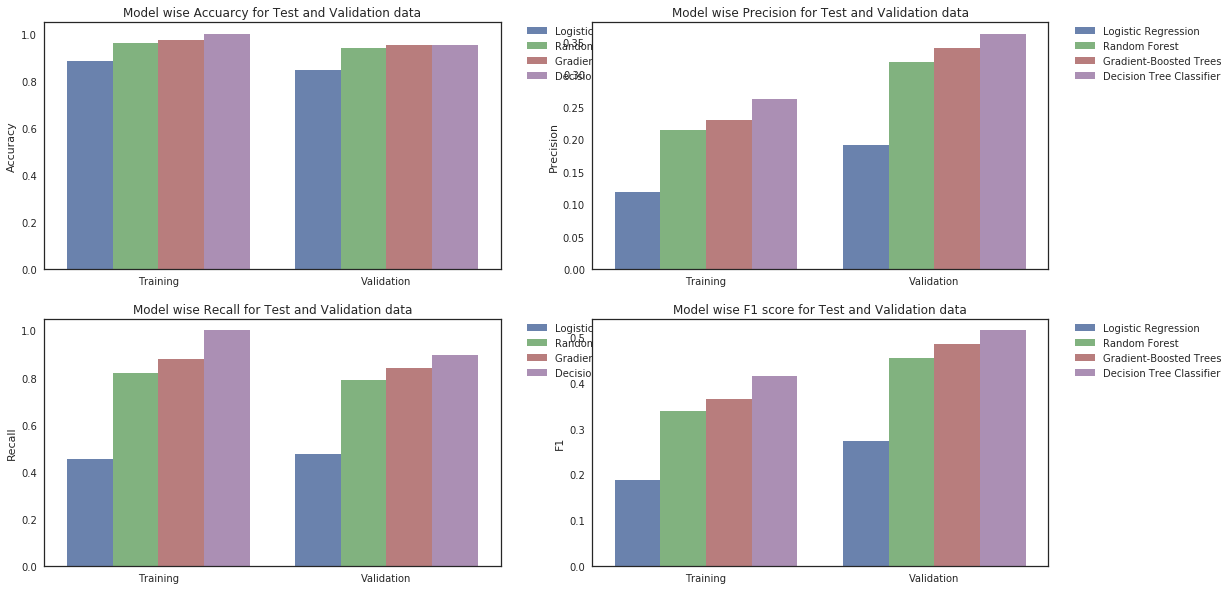

In [252]:
# Plot metrics for algorithm
f, axes = plt.subplots(2, 2, figsize=(18, 10))

sbn.set(style="white", palette="muted", color_codes=True)

titles = [["Model wise Accuarcy for Test and Validation data", "Model wise Precision for Test and Validation data" ],
          ["Model wise Recall for Test and Validation data", "Model wise F1 score for Test and Validation data" ]
         ]

k = 0
for i,a in enumerate(axes):
    for j,ax in enumerate(a):
        ax = sbn.barplot(data=ml_metrics, x=ml_metrics.index, y=ml_metrics.columns[k], hue='model', 
                         ax=axes[i,j], saturation=0.50); 
        ax.set_title(titles[i][j]);
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
        k += 1

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show();

#### With Standard Scalling of  features , We could see that `Decision Trees Classsifer` algorthim  performs better with `0.515` F1 score on validation set. `0.515` is not a great F1 score. There is scope for more hyperparameter tuning and train the model on larger dataser and using more  `categorical` features.

# Conclusion

The experiment is done here with small set of data of 2 months. There features were computed on each day basis to account for the variation of data over time. There are 29 features extracted from raw log data. The featured dataframe is then used to for ML models.  There are 5 binary classification algorthms used to evaluate the metrics. Out of 4 models `Decision Tress Classifer` proved to be better in overall metrics with `Standard Scaled` features.

Though Initial set out to work with `mini-sparkify-event-data.json` to understand what data and algorithm suitable for this data.  There is a scope for further hyperparameter tuning. Then the model also needs to be pacakged as Class and pacakges for deployment.

                                                 ** end of project **